In [1]:
using Distributions
using Random
using DelimitedFiles
using ParticleFilters
using PyPlot
using StatsBase
using Images
using BenchmarkTools
using CUDA

## Load Data

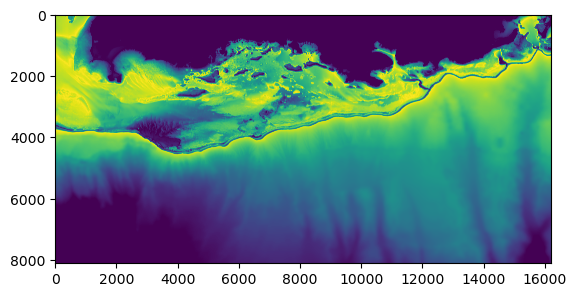

In [3]:
# Open the tiff file
# filename = "/home/amy/final_project_18337/PuertoRico_SouthWest_Color.tif"
filename = "PuertoRico_SouthWest_Color.tif"
img = load(filename)

function rgb_to_value(rgb_color::RGB{N0f8})
    # Interpolate between blue and red based on the green component
    green_component = green(rgb_color)
    value = 30-30 * (1 - green_component)

    # Return the value
    return value
end

# Convert from pixels to meters and vice versa
# ~40 miles, 16000px wide
# ~64000 meters

px_per_meter = 16000/64000

function px_to_meters(px)
    return px./px_per_meter
end

function meters_to_px(m)
    return m.*px_per_meter
end

function lookup_depth(x, y, map)
    # In meters
    # column, row (x, y) format. 0, 0 is top left of image    
    
    # Find the pixel with the closest x, y values
    x_idx = argmin(abs.(collect(1:size(map, 2)) .- x))
    y_idx = argmin(abs.(collect(1:size(map, 1)) .- y))
    
    # Look up the pixel value
    pixel_value = map[y_idx, x_idx] 
    
    return pixel_value 
end

# TODO: Fix mapping error - currently using pixels, NOT meters

# Apply the rgb_to_value function to the image
value_image = map(rgb_to_value, img)

# Display the value image
imshow(value_image)

bathy_map = value_image[1500:2500,6000:8000];

## Constants

In [4]:
SIM_TIME = 1000 # s
N_STEPS = 1001

SIM_MEASUREMENT_STD = 10 # Noise of simulated measurement
MODEL_MEASUREMENT_STD = 0.1 # Modeled noise value

ts = range(0, stop=SIM_TIME, length=N_STEPS)

# TODO: remove fixed timestamp
DELTA_T = ts[2] - ts[1]
rng = MersenneTwister(1)

MersenneTwister(1)

In [5]:
# Particle filter parameters
N_PARTICLES = 1000
INIT_STD_POS = 100 # Positional standard deviation
INIT_STD_ROT = 1 # Rotational standard deviation (radians)

PF_STD_POS = 0.1 # Positional standard deviation for particle filter updates
PF_STD_ROT = 0.01 # Positional standard deviation for particle filter updates


STATE_VEC_SIZE = 5 # x, y, θ, linear velocity, angular velocity

5

## Particle Filter Models

In [50]:
# Dyanmics Model
function glider_dynamics_model(x, u, rng)
    """
    inputs:
        x: state
        u: control input
    output:
        updated state (same shape as x)
    """
    
    x_pos, y_pos, θ, v, dθ = x
    in_thruster, in_rudder = u
    
    # Update position based on state
    x_step = x_pos + DELTA_T*v*cos(θ)
    y_step = y_pos + DELTA_T*v*sin(θ)
    θ_step = θ + DELTA_T*dθ

    # Update velocities based on input
    v_step = v + DELTA_T*(in_thruster-v)
    dθ_step = dθ + DELTA_T*in_rudder
    
    return [x_step, y_step, θ_step, v_step, dθ_step]
end

# Measurement model (computes likelihood of measurement, given previous state, action, and current state)
# Note: our measurement only depends on current state
function glider_measurement_model(x1, u, x2, y)
    """
    inputs:
        x1: current state
        u: control input
        x2: next state
        y: measurement
    output:
        likelihood (float)
    """
    
    # State vector: x, y, θ, linear velocity, angular velocity
    x_pos, y_pos, θ, v, dθ = x2
    measured_depth = y

    model_depth = lookup_depth(x_pos, y_pos, bathy_map)

    dist = Normal(model_depth, MODEL_MEASUREMENT_STD)
    pdf_value = pdf(dist, measured_depth)

    return pdf_value
end

glider_measurement_model (generic function with 1 method)

## Generate Dataset

In [51]:
function generate_random_func()
    n = 5
    a = 0.05
    A = rand(-a:0.01:a, n)
    B = rand(-a:0.01:a, n)
    random_func(t) = sum(A[i]*sin.(B[i]*t) * A[i+1]*cos.(B[i+1]*t) for i in 1:n-1)
    return random_func
end

function generate_data(ts, func)
    output = similar(ts)
    for (i, t) in enumerate(ts)
        output[i] = func(t)
    end
    return output
end

function simulate_trajectory(ts, in_thruster, in_rudder; start_x=0, start_y=0, start_θ=0)
    xs = similar(ts)
    ys = similar(ts)
    vs = similar(ts)
    θs  = similar(ts)
    dθs = similar(ts)
    
    # Initialize state to 0
    xs[1] = start_x # X position
    ys[1] = start_y # Y position
    vs[1] = 0 # Velocity
    θs[1] = start_θ # Heading
    dθs[1] = 0 # Angular Velocity
    
    for (i, t) in enumerate(ts[1:end-1])
        state = [xs[i], ys[i], θs[i], vs[i], dθs[i]]
        u = [in_thruster[i], in_rudder[i]]
        xs[i+1], ys[i+1], θs[i+1], vs[i+1], dθs[i+1] = 
            glider_dynamics_model(state, u, rng)
    end
    
    return xs, ys, θs, vs, dθs
end

function simulate_measurements(xs, ys, map)
    # TODO: Add noise terms
    output = similar(xs)
    
    for (i, (x, y)) in enumerate(zip(xs, ys))
        output[i] = lookup_depth(x, y, map)
    end
    
    return output
end

simulate_measurements (generic function with 1 method)

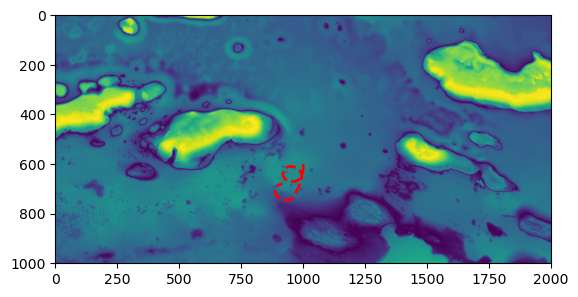

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000002A1C43BCEB0>

In [52]:
START_X = 1000 
START_Y = 600
START_θ = π/2

# in_thruster = generate_data(ts, generate_random_func())
in_thruster = 0.5*ones(size(ts))
in_rudder = 0.1*generate_data(ts, generate_random_func())

xs, ys, θs, vs, dθs = simulate_trajectory(ts, in_thruster, in_rudder, 
    start_x=START_X, start_y=START_Y, start_θ=START_θ)

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(xs,ys,"r--", lw=2)

In [53]:
measurements = simulate_measurements(xs, ys, bathy_map);

## ParticleFilters.jl

In [54]:
function compute_initial_particles()
    init_particles = Vector{Vector{Float64}}(undef, N_PARTICLES)
    
    dist_pos_init = Normal(0, INIT_STD_POS)
    dist_rot_init = Normal(0, INIT_STD_ROT)
    
    for i in 1:N_PARTICLES
        # Generate sample
        x = START_X + rand(dist_pos_init)
        y = START_Y + rand(dist_pos_init)
        θ = START_θ + rand(dist_rot_init)
        init_particles[i] = [x, y, θ, 0, 0]
    end

    return init_particles
end

compute_initial_particles (generic function with 1 method)

In [55]:
pf_model = ParticleFilterModel{Vector{Float64}}(glider_dynamics_model, glider_measurement_model);

fil = BootstrapFilter(pf_model, N_PARTICLES) # Takes in model, number of particles

# construct initial belief
b0 = ParticleCollection(compute_initial_particles())

# Temporary---------------------------------
inputs = [in_thruster, in_rudder]

# Preallocate the output vector for performance
us = Vector{Vector{Float64}}(undef, length(in_thruster))

# Convert each pair of values to a vector and store in the output vector
for i in 1:length(in_thruster)
    us[i] = [inputs[1][i], inputs[2][i]]
end
# ------------------------------------------

bs = runfilter(fil, b0, us, measurements); # Actually compute results. Inputs: filter, initial particles, data 

In [56]:
# @btime runfilter(fil, b0, us, measurements); # Actually compute results. Inputs: filter, initial particles, data 

In [57]:
# @btime 3
results = @benchmark runfilter(fil, b0, us, measurements) evals=1 samples=1

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 14.102 s (14.74% GC) to evaluate,
 with a memory estimate of 46.04 GiB, over 36016987 allocations.

In [58]:
# results = @benchmark 3 evals=1000 samples=1

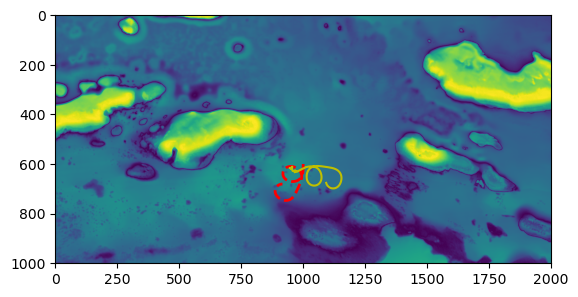

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000002A1C4423AC0>

In [59]:
# TODO: make this less redundant
filtered_xs = [m[1] for m in map(mean, bs)]
filtered_ys = [m[2] for m in map(mean, bs)]

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(xs,ys,"r--", lw=2)
ax.plot(filtered_xs, filtered_ys, "y")

## Custom ParticleFilter 

In [60]:
all_particles = ones(STATE_VEC_SIZE, N_PARTICLES, N_STEPS)
particles = ones(STATE_VEC_SIZE, N_PARTICLES)
new_particles = ones(STATE_VEC_SIZE, N_PARTICLES)
weights = ones(N_PARTICLES)


dist_pos_init = Normal(0, INIT_STD_POS)
dist_rot_init = Normal(0, INIT_STD_ROT)

dist_pos_update = Normal(0, PF_STD_POS)
dist_rot_update = Normal(0, PF_STD_ROT)


for i in range(1, N_PARTICLES)
    # Generate sample
    x = START_X + rand(dist_pos_init)
    y = START_Y + rand(dist_pos_init)
    θ = START_θ + rand(dist_rot_init)
    
    particles[:,i] = particles[:,i].*[x, y, θ, 0, 0]
end

In [122]:
zeros(Float32, N_PARTICLES)
x

1000-element Vector{Float32}:
  834.8389
  955.6978
  942.3854
 1190.4514
  972.9618
 1162.5566
 1218.5931
  880.34515
  994.4103
  928.77985
  900.5054
 1015.3712
 1051.9698
    ⋮
 1092.7632
  919.818
 1032.1494
  855.7799
 1121.1163
  998.7642
 1077.5988
 1020.2352
 1069.8147
  921.37946
  869.0386
  955.29565

In [137]:

# Load initial particles onto GPU (_d means stored on device)
using CUDA

# Initialize particles
x = Float32.(START_X .+ rand(dist_pos_init, N_PARTICLES))
y = Float32.(START_Y .+ rand(dist_pos_init, N_PARTICLES))
θ = Float32.(START_θ .+ rand(dist_rot_init, N_PARTICLES))
v = zeros(Float32, N_PARTICLES)
dθ = zeros(Float32, N_PARTICLES)

# Particles = Vector containing CuArray for each state variable 
# Vector{CuArray}(undef, 5)
particles_d = cu([x', y', θ', v', dθ'])

# Load measurements and control inputs onto GPU
in_thruster_32 = Float32.(in_thruster)
in_rudder_32 = Float32.(in_rudder)
inputs_d = cu([in_thruster_32', in_rudder_32'])

measurements_32 = Float32.(measurements)
measurements_d = cu([measurements_32'])


# function parallel_add!(y, x)
#     Threads.@threads for i in eachindex(y, x)
#         @inbounds y[i] += x[i]
#     end
#     return nothing
# end



1-element CuArray{LinearAlgebra.Adjoint{Float32, Vector{Float32}}, 1, CUDA.Mem.DeviceBuffer}:
 [15.529412 15.529412 … 15.764707 15.764707]

In [94]:
# test = cu([rand(dist_pos_init, N_PARTICLES); rand(dist_pos_init, N_PARTICLES)])
# test[1]

temp1 = [1,2,3]
temp2 = [4,5,6]
A = Float32[temp1'; temp2']

# Create a 2x3 matrix on the GPU with Float32 element type
A_d = cu(A)

2×3 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 1.0  2.0  3.0
 4.0  5.0  6.0

In [95]:
typeof(measurements_d)

Vector{CuArray{Float32, 1, DeviceBuffer}} (alias for Array{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, 1})

In [96]:
# function gpu_add3!(y, x)
#     index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
#     stride = gridDim().x * blockDim().x
#     for i = index:stride:length(y)
#         @inbounds y[i] += x[i]
#     end
#     return
# end

In [144]:
# # function run_gpu_filter!(particles, dynamics_model, measurement_model, inputs, measurements)
    
# # end

# function update_weights_gpu!(particles, input, measurement, measurement_model, weights)
#     index = (blockIdx().particles - 1) * blockDim().particles + threadIdx().particles
#     stride = gridDim().particles * blockDim().particles
#     for i = index:stride:length(particles)       
#         # TODO: Add support for measurement models that depend on next state
#         # Replace 0 with next state data
#         @inbounds weights[i] = measurement_model(particles[i], input, 0, measurement)
#     end
# end

# function run_gpu_filter!(particles, inputs, measurements, measurement_model, dynamics_model)
#     # Initialize weights vector
#     weights_d = CUDA.fill(1.0f0, length(particles))
    
#     for (u, y) in enumerate(zip(inputs, measurements))
#         print('.')
        
#         # TODO: Ensure likelihood can't be too small
#         update_weights_gpu!(particles, u, y, measurement_model, weights_d)
#     end
# end

# function bench_gpu_filter!(particles, inputs, measurements, measurement_model, dynamics_model)
# # function bench_gpu_filter!(particles, func)
#     kernel = @cuda launch=false run_gpu_filter!(particles, inputs, measurements, measurement_model, dynamics_model)
#     config = launch_configuration(kernel.fun)
#     threads = min(length(particles), config.threads)
#     blocks = cld(length(particles), threads)

#     display(threads)
#     display(blocks)

#     CUDA.@sync begin
#         kernel(particles, inputs, measurements, measurement_model, dynamics_model; threads, blocks)
# #         kernel(particles, func; threads, blocks)
#     end
# end

# bench_gpu_filter!(particles_d, inputs_d, measurements_d, glider_measurement_model, glider_dynamics_model)
# bench_gpu_filter!(particles_d, inputs_d, measurements_d)



# # function test_func!(part)
# #     display(part[1])
# #     display("here")
# #     @cuprintln("print testing")
# #     @cuprintln(part[1])
# # end

# # bench_gpu_filter!(particles_d, test_func!)

# # test_func!(particles_d)



# # # @btime bench_gpu4!($y_d, $x_d)

# # # run_gpu_filter!(particles_d, inputs_d, measurements_d)

# # @cuda threads=16 run_gpu_filter!(particles_d, inputs_d, measurements_d, glider_measurement_model, glider_dynamics_model)
# # synchronize()

LoadError: InvalidIRError: compiling MethodInstance for run_gpu_filter!(::CuDeviceVector{LinearAlgebra.Adjoint{Float32, Vector{Float32}}, 1}, ::CuDeviceVector{LinearAlgebra.Adjoint{Float32, Vector{Float32}}, 1}, ::CuDeviceVector{LinearAlgebra.Adjoint{Float32, Vector{Float32}}, 1}, ::typeof(glider_measurement_model), ::typeof(glider_dynamics_model)) resulted in invalid LLVM IR
[31mReason: unsupported call through a literal pointer[39m[31m (call to memcmp)[39m
Stacktrace:
 [1] [0m[1m_memcmp[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:113[24m[39m
 [2] [0m[1m==[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:125[24m[39m
 [3] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:152[24m[39m
 [4] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mmemoization.jl:78[24m[39m
 [5] [0m[1mstream_ordered[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:151[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to memcmp)[39m
Stacktrace:
 [1] [0m[1m_memcmp[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:113[24m[39m
 [2] [0m[1mendswith[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mutil.jl:76[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
 [1] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
 [1] [0m[1menable_finalizers[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
 [2] [0m[1m_trylock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:89[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to ident_cmp)[39m
Stacktrace:
 [1] [0m[1m==[22m
[90m   @ [39m[90m.\[39m[90m[4mversion.jl:187[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to ident_cmp)[39m
Stacktrace:
 [1] [0m[1m==[22m
[90m   @ [39m[90m.\[39m[90m[4mversion.jl:188[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to hash)[39m
Stacktrace:
 [1] [0m[1mhash[22m
[90m   @ [39m[90m.\[39m[90m[4mversion.jl:218[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to hash)[39m
Stacktrace:
 [1] [0m[1mhash[22m
[90m   @ [39m[90m.\[39m[90m[4mversion.jl:219[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to get!(constructor, x::CUDA.APIUtils.LazyInitialized; hook) in CUDA.APIUtils at C:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\threading.jl:24)[39m
Stacktrace:
 [1] [0m[1mdevice_contexts[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:195[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to lock)[39m
Stacktrace:
  [1] [0m[1m_wait[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:301[24m[39m
  [2] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:395[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
  [1] [0m[1m_wait[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:302[24m[39m
  [2] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:395[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
  [1] [0m[1m_wait[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:302[24m[39m
  [2] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:395[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to wait)[39m
Stacktrace:
  [1] [0m[1m_wait[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:304[24m[39m
  [2] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:395[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
  [1] [0m[1m_wait[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:305[24m[39m
  [2] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:395[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to unlock)[39m
Stacktrace:
  [1] [0m[1m_wait[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:307[24m[39m
  [2] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:395[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
 [1] [0m[1m#alloc#163[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:399[24m[39m
 [2] [0m[1malloc[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [3] [0m[1mCuArray[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [4] [0m[1mCuArray[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [5] [0m[1mCuArray[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [6] [0m[1mCuArray[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [7] [0m[1mfill[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [8] [0m[1mrun_gpu_filter![22m
[90m   @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_box_char)[39m
Stacktrace:
 [1] [0m[1mprint[22m
[90m   @ [39m[90m.\[39m[90m[4mcoreio.jl:3[24m[39m
 [2] [0m[1mrun_gpu_filter![22m
[90m   @ [39m[90m.\[39m[90m[4mIn[144]:20[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to print)[39m
Stacktrace:
 [1] [0m[1mprint[22m
[90m   @ [39m[90m.\[39m[90m[4mcoreio.jl:3[24m[39m
 [2] [0m[1mrun_gpu_filter![22m
[90m   @ [39m[90m.\[39m[90m[4mIn[144]:20[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_rethrow)[39m
Stacktrace:
 [1] [0m[1mrethrow[22m
[90m   @ [39m[90m.\[39m[90m[4merror.jl:61[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
 [1] [0m[1menable_finalizers[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
 [2] [0m[1mtrylock[22m
[90m   @ [39m[90m.\[39m[90m[4mlocks-mt.jl:57[24m[39m
 [3] [0m[1mlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlocks-mt.jl:41[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
Stacktrace:
 [1] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:899[24m[39m
 [2] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [3] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
Stacktrace:
 [1] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:899[24m[39m
 [2] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [3] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
 [1] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:899[24m[39m
 [2] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [3] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
Stacktrace:
 [1] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:899[24m[39m
 [2] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [3] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mlist_deletefirst![22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:696[24m[39m
 [2] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:899[24m[39m
 [3] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [4] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mlist_deletefirst![22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:696[24m[39m
 [2] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:899[24m[39m
 [3] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [4] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mlist_deletefirst![22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:697[24m[39m
 [2] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:899[24m[39m
 [3] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [4] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
 [1] [0m[1menable_finalizers[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
 [2] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlocks-mt.jl:66[24m[39m
 [3] [0m[1mlist_deletefirst![22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:699[24m[39m
 [4] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:899[24m[39m
 [5] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [6] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
Stacktrace:
 [1] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:899[24m[39m
 [2] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [3] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
  [1] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:536[24m[39m
  [2] [0m[1mcuCtxPushCurrent_v2[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
  [3] [0m[1mpush![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mcontext.jl:162[24m[39m
  [4] [0m[1mdevice[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mcontext.jl:286[24m[39m
  [5] [0m[1mcheck_exceptions[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\compiler\[39m[90m[4mexceptions.jl:33[24m[39m
  [6] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:134[24m[39m
  [7] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
  [1] [0m[1munsafe_cuCtxGetDevice[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2980[24m[39m
  [2] [0m[1mcurrent_device[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mdevices.jl:23[24m[39m
  [3] [0m[1mdevice[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mcontext.jl:287[24m[39m
  [4] [0m[1mcheck_exceptions[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\compiler\[39m[90m[4mexceptions.jl:33[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:134[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
  [1] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:532[24m[39m
  [2] [0m[1mcuCtxPopCurrent_v2[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
  [3] [0m[1mpop![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mcontext.jl:171[24m[39m
  [4] [0m[1mdevice[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mcontext.jl:288[24m[39m
  [5] [0m[1mcheck_exceptions[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\compiler\[39m[90m[4mexceptions.jl:33[24m[39m
  [6] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:134[24m[39m
  [7] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
  [1] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
  [2] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:468[24m[39m
  [3] [0m[1mzeros[22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:588[24m[39m
  [4] [0m[1mzeros[22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:584[24m[39m
  [5] [0m[1mDict[22m
[90m    @ [39m[90m.\[39m[90m[4mdict.jl:90[24m[39m
  [6] [0m[1mSet[22m
[90m    @ [39m[90m.\[39m[90m[4mset.jl:9[24m[39m
  [7] [0m[1m#unique!#350[22m
[90m    @ [39m[90m.\[39m[90m[4mset.jl:283[24m[39m
  [8] [0m[1munique![22m
[90m    @ [39m[90m.\[39m[90m[4mset.jl:274[24m[39m
  [9] [0m[1m_unique![22m
[90m    @ [39m[90m.\[39m[90m[4mset.jl:312[24m[39m
 [10] [0m[1munique![22m
[90m    @ [39m[90m.\[39m[90m[4mset.jl:378[24m[39m
 [11] [0m[1mmultiple call sites[22m
[90m    @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1mDict[22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:90[24m[39m
 [3] [0m[1mSet[22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:9[24m[39m
 [4] [0m[1m#unique!#350[22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:283[24m[39m
 [5] [0m[1munique![22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:274[24m[39m
 [6] [0m[1m_unique![22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:312[24m[39m
 [7] [0m[1munique![22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:378[24m[39m
 [8] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to GetLastError)[39m
Stacktrace:
 [1] [0m[1mGetLastError[22m
[90m   @ [39m[90m.\[39m[90m[4mlibc.jl:316[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_string)[39m
Stacktrace:
 [1] [0m[1m_string_n[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:78[24m[39m
 [2] [0m[1mstring[22m
[90m   @ [39m[90m.\strings\[39m[90m[4msubstring.jl:234[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
Stacktrace:
 [1] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
Stacktrace:
 [1] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
Stacktrace:
 [1] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:222[24m[39m
 [2] [0m[1mis_root_module[22m
[90m   @ [39m[90m.\[39m[90m[4mloading.jl:1217[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:222[24m[39m
 [2] [0m[1mis_root_module[22m
[90m   @ [39m[90m.\[39m[90m[4mloading.jl:1217[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:223[24m[39m
 [2] [0m[1mis_root_module[22m
[90m   @ [39m[90m.\[39m[90m[4mloading.jl:1217[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
 [1] [0m[1menable_finalizers[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
 [2] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:133[24m[39m
 [3] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:225[24m[39m
 [4] [0m[1mis_root_module[22m
[90m   @ [39m[90m.\[39m[90m[4mloading.jl:1217[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_eqtable_get)[39m
Stacktrace:
 [1] [0m[1mget[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:102[24m[39m
 [2] [0m[1min[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:189[24m[39m
 [3] [0m[1mhaskey[22m
[90m   @ [39m[90m.\[39m[90m[4mabstractdict.jl:17[24m[39m
 [4] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:223[24m[39m
 [5] [0m[1mis_root_module[22m
[90m   @ [39m[90m.\[39m[90m[4mloading.jl:1217[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
Stacktrace:
 [1] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1mgetindex[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:404[24m[39m
 [3] [0m[1mtranscode[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:311[24m[39m
 [4] [0m[1mcwstring[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:250[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_sizehint)[39m
Stacktrace:
 [1] [0m[1msizehint![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1267[24m[39m
 [2] [0m[1mtranscode[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:314[24m[39m
 [3] [0m[1mcwstring[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:250[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mpush![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1058[24m[39m
 [3] [0m[1mtranscode[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:324[24m[39m
 [4] [0m[1mcwstring[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:250[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mpush![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1058[24m[39m
 [3] [0m[1mtranscode[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:331[24m[39m
 [4] [0m[1mcwstring[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:250[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mpush![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1058[24m[39m
 [3] [0m[1mtranscode[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:338[24m[39m
 [4] [0m[1mcwstring[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:250[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mpush![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1058[24m[39m
 [3] [0m[1mtranscode[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:321[24m[39m
 [4] [0m[1mcwstring[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:250[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mpush![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1058[24m[39m
 [3] [0m[1mtranscode[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:352[24m[39m
 [4] [0m[1mcwstring[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:250[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_string)[39m
Stacktrace:
 [1] [0m[1m_string_n[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:78[24m[39m
 [2] [0m[1mgetindex[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:271[24m[39m
 [3] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:82[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_try_substrtod)[39m
Stacktrace:
 [1] [0m[1mtryparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:248[24m[39m
 [2] [0m[1m#tryparse_internal#478[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:367[24m[39m
 [3] [0m[1mtryparse_internal[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:366[24m[39m
 [4] [0m[1m#parse#479[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:379[24m[39m
 [5] [0m[1mparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:379[24m[39m
 [6] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:83[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to _parse_failure(T, s::AbstractString) in Base at parse.jl:373)[39m
Stacktrace:
 [1] [0m[1m#tryparse_internal#478[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:369[24m[39m
 [2] [0m[1mtryparse_internal[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:366[24m[39m
 [3] [0m[1m#parse#479[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:379[24m[39m
 [4] [0m[1mparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:379[24m[39m
 [5] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:83[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1mvect[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:147[24m[39m
 [3] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:86[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_f_getfield)[39m
Stacktrace:
 [1] [0m[1mgetindex[22m
[90m   @ [39m[90m.\[39m[90m[4mtuple.jl:29[24m[39m
 [2] [0m[1miterate[22m
[90m   @ [39m[90m.\[39m[90m[4mtuple.jl:68[24m[39m
 [3] [0m[1mcopyto![22m
[90m   @ [39m[90m.\[39m[90m[4mabstractarray.jl:906[24m[39m
 [4] [0m[1mvect[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:147[24m[39m
 [5] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:86[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_string)[39m
Stacktrace:
 [1] [0m[1m_string_n[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:78[24m[39m
 [2] [0m[1mgetindex[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:271[24m[39m
 [3] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:90[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_try_substrtod)[39m
Stacktrace:
 [1] [0m[1mtryparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:248[24m[39m
 [2] [0m[1m#tryparse_internal#478[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:367[24m[39m
 [3] [0m[1mtryparse_internal[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:366[24m[39m
 [4] [0m[1m#parse#479[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:379[24m[39m
 [5] [0m[1mparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:379[24m[39m
 [6] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:91[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to _parse_failure(T, s::AbstractString) in Base at parse.jl:373)[39m
Stacktrace:
 [1] [0m[1m#tryparse_internal#478[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:369[24m[39m
 [2] [0m[1mtryparse_internal[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:366[24m[39m
 [3] [0m[1m#parse#479[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:379[24m[39m
 [4] [0m[1mparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:379[24m[39m
 [5] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:91[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:468[24m[39m
 [3] [0m[1msimilar[22m
[90m   @ [39m[90m.\[39m[90m[4mabstractarray.jl:841[24m[39m
 [4] [0m[1msimilar[22m
[90m   @ [39m[90m.\[39m[90m[4mabstractarray.jl:840[24m[39m
 [5] [0m[1m_array_for[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:676[24m[39m
 [6] [0m[1m_array_for[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:679[24m[39m
 [7] [0m[1mvect[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:126[24m[39m
 [8] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:95[24m[39m
 [9] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_string)[39m
Stacktrace:
 [1] [0m[1m_string_n[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:78[24m[39m
 [2] [0m[1mgetindex[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:271[24m[39m
 [3] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:99[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_try_substrtod)[39m
Stacktrace:
 [1] [0m[1mtryparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:248[24m[39m
 [2] [0m[1m#tryparse_internal#478[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:367[24m[39m
 [3] [0m[1mtryparse_internal[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:366[24m[39m
 [4] [0m[1m#parse#479[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:379[24m[39m
 [5] [0m[1mparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:379[24m[39m
 [6] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:100[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to _parse_failure(T, s::AbstractString) in Base at parse.jl:373)[39m
Stacktrace:
 [1] [0m[1m#tryparse_internal#478[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:369[24m[39m
 [2] [0m[1mtryparse_internal[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:366[24m[39m
 [3] [0m[1m#parse#479[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:379[24m[39m
 [4] [0m[1mparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:379[24m[39m
 [5] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:100[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to var"#sprint#452"(context, sizehint::Integer, ::typeof(sprint), f::Function, args...) in Base at strings/io.jl:107)[39m
Stacktrace:
 [1] [0m[1m#repr#455[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [2] [0m[1mrepr[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [3] [0m[1mtryparse_internal[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:117[24m[39m
 [4] [0m[1m#parse#477[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:241[24m[39m
 [5] [0m[1mparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:240[24m[39m
 [6] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:104[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to var"#sprint#452"(context, sizehint::Integer, ::typeof(sprint), f::Function, args...) in Base at strings/io.jl:107)[39m
Stacktrace:
 [1] [0m[1m#repr#455[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [2] [0m[1mrepr[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [3] [0m[1mtryparse_internal[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:122[24m[39m
 [4] [0m[1m#parse#477[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:241[24m[39m
 [5] [0m[1mparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:240[24m[39m
 [6] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:104[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_box_char)[39m
Stacktrace:
 [1] [0m[1m#repr#455[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [2] [0m[1mrepr[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [3] [0m[1mtryparse_internal[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:137[24m[39m
 [4] [0m[1m#parse#477[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:241[24m[39m
 [5] [0m[1mparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:240[24m[39m
 [6] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:104[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to var"#sprint#452"(context, sizehint::Integer, ::typeof(sprint), f::Function, args...) in Base at strings/io.jl:107)[39m
Stacktrace:
 [1] [0m[1m#repr#455[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [2] [0m[1mrepr[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [3] [0m[1mtryparse_internal[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:137[24m[39m
 [4] [0m[1m#parse#477[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:241[24m[39m
 [5] [0m[1mparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:240[24m[39m
 [6] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:104[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_box_char)[39m
Stacktrace:
 [1] [0m[1m#repr#455[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [2] [0m[1mrepr[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [3] [0m[1mtryparse_internal[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:155[24m[39m
 [4] [0m[1m#parse#477[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:241[24m[39m
 [5] [0m[1mparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:240[24m[39m
 [6] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:104[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to var"#sprint#452"(context, sizehint::Integer, ::typeof(sprint), f::Function, args...) in Base at strings/io.jl:107)[39m
Stacktrace:
 [1] [0m[1m#repr#455[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [2] [0m[1mrepr[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [3] [0m[1mtryparse_internal[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:155[24m[39m
 [4] [0m[1m#parse#477[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:241[24m[39m
 [5] [0m[1mparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:240[24m[39m
 [6] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:104[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to var"#sprint#452"(context, sizehint::Integer, ::typeof(sprint), f::Function, args...) in Base at strings/io.jl:107)[39m
Stacktrace:
 [1] [0m[1m#repr#455[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [2] [0m[1mrepr[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [3] [0m[1mtryparse_internal[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:163[24m[39m
 [4] [0m[1m#parse#477[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:241[24m[39m
 [5] [0m[1mparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:240[24m[39m
 [6] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:104[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to var"#sprint#452"(context, sizehint::Integer, ::typeof(sprint), f::Function, args...) in Base at strings/io.jl:107)[39m
Stacktrace:
 [1] [0m[1m#repr#455[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [2] [0m[1mrepr[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [3] [0m[1mtryparse_internal[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:172[24m[39m
 [4] [0m[1m#parse#477[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:241[24m[39m
 [5] [0m[1mparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:240[24m[39m
 [6] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:104[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to uv_asynccb)[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_object_id_)[39m
Stacktrace:
 [1] [0m[1mobjectid[22m
[90m   @ [39m[90m.\[39m[90m[4mreflection.jl:340[24m[39m
 [2] [0m[1mhash[22m
[90m   @ [39m[90m.\[39m[90m[4mhashing.jl:25[24m[39m
 [3] [0m[1mhash[22m
[90m   @ [39m[90m.\[39m[90m[4mhashing.jl:20[24m[39m
 [4] [0m[1mhashindex[22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:169[24m[39m
 [5] [0m[1mht_keyindex2![22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:309[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2976[24m[39m
 [2] [0m[1mcuCtxGetCurrent[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mprepare_cuda_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:100[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2972[24m[39m
 [2] [0m[1mcuCtxSetCurrent[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mactivate[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mcontext.jl:181[24m[39m
 [4] [0m[1mprepare_cuda_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:102[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to convert)[39m
Stacktrace:
 [1] [0m[1m#parse#477[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:241[24m[39m
 [2] [0m[1mparse[22m
[90m   @ [39m[90m.\[39m[90m[4mparse.jl:240[24m[39m
 [3] [0m[1mparse_limit[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:104[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2870[24m[39m
 [2] [0m[1mcuDriverGetVersion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mdriver_version[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mversion.jl:12[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1myield[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:814[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1myield[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:814[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1myield[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:815[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to list_deletefirst!)[39m
Stacktrace:
 [1] [0m[1myield[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:817[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_string)[39m
Stacktrace:
 [1] [0m[1m_string_n[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:78[24m[39m
 [2] [0m[1mStringVector[22m
[90m   @ [39m[90m.\[39m[90m[4miobuffer.jl:31[24m[39m
 [3] [0m[1m#IOBuffer#423[22m
[90m   @ [39m[90m.\[39m[90m[4miobuffer.jl:114[24m[39m
 [4] [0m[1mprint_to_string[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:142[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_string_to_array)[39m
Stacktrace:
 [1] [0m[1munsafe_wrap[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:89[24m[39m
 [2] [0m[1mStringVector[22m
[90m   @ [39m[90m.\[39m[90m[4miobuffer.jl:31[24m[39m
 [3] [0m[1m#IOBuffer#423[22m
[90m   @ [39m[90m.\[39m[90m[4miobuffer.jl:114[24m[39m
 [4] [0m[1mprint_to_string[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:142[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mresize![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1236[24m[39m
 [3] [0m[1mrehash![22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:184[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_del_end)[39m
Stacktrace:
 [1] [0m[1m_deleteend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1020[24m[39m
 [2] [0m[1mresize![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1241[24m[39m
 [3] [0m[1mrehash![22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:184[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mresize![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1236[24m[39m
 [3] [0m[1mrehash![22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:186[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_del_end)[39m
Stacktrace:
 [1] [0m[1m_deleteend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1020[24m[39m
 [2] [0m[1mresize![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1241[24m[39m
 [3] [0m[1mrehash![22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:186[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mresize![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1236[24m[39m
 [3] [0m[1mrehash![22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:187[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_del_end)[39m
Stacktrace:
 [1] [0m[1m_deleteend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1020[24m[39m
 [2] [0m[1mresize![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1241[24m[39m
 [3] [0m[1mrehash![22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:187[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:468[24m[39m
 [3] [0m[1mzeros[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:588[24m[39m
 [4] [0m[1mzeros[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:584[24m[39m
 [5] [0m[1mrehash![22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:192[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1mrehash![22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:193[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1mrehash![22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:194[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_object_id_)[39m
Stacktrace:
 [1] [0m[1mobjectid[22m
[90m   @ [39m[90m.\[39m[90m[4mreflection.jl:340[24m[39m
 [2] [0m[1mhash[22m
[90m   @ [39m[90m.\[39m[90m[4mhashing.jl:25[24m[39m
 [3] [0m[1mhash[22m
[90m   @ [39m[90m.\[39m[90m[4mhashing.jl:20[24m[39m
 [4] [0m[1mhashindex[22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:169[24m[39m
 [5] [0m[1mrehash![22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:203[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
Stacktrace:
  [1] [0m[1merrormonitor[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:561[24m[39m
  [2] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:175[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [5] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [6] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [7] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [12] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [13] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
  [1] [0m[1merrormonitor[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:561[24m[39m
  [2] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:175[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [5] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [6] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [7] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [12] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [13] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
Stacktrace:
  [1] [0m[1merrormonitor[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:561[24m[39m
  [2] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:175[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [5] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [6] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [7] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [12] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [13] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
Stacktrace:
  [1] [0m[1merrormonitor[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:561[24m[39m
  [2] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:175[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [5] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [6] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [7] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [12] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [13] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to lock)[39m
Stacktrace:
  [1] [0m[1m_wait2[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:316[24m[39m
  [2] [0m[1merrormonitor[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:561[24m[39m
  [3] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:175[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [6] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [7] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [8] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [13] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [14] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to getproperty)[39m
Stacktrace:
  [1] [0m[1m_wait2[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:318[24m[39m
  [2] [0m[1merrormonitor[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:561[24m[39m
  [3] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:175[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [6] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [7] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [8] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [13] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [14] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to push!)[39m
Stacktrace:
  [1] [0m[1m_wait2[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:318[24m[39m
  [2] [0m[1merrormonitor[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:561[24m[39m
  [3] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:175[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [6] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [7] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [8] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [13] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [14] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to unlock)[39m
Stacktrace:
  [1] [0m[1m_wait2[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:319[24m[39m
  [2] [0m[1merrormonitor[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:561[24m[39m
  [3] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:175[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [6] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [7] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [8] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [13] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [14] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_get_task_tid)[39m
Stacktrace:
  [1] [0m[1mthreadid[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:253[24m[39m
  [2] [0m[1m_wait2[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:322[24m[39m
  [3] [0m[1merrormonitor[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:561[24m[39m
  [4] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:175[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [7] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [8] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [9] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [14] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [15] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_set_task_tid)[39m
Stacktrace:
  [1] [0m[1m_wait2[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:330[24m[39m
  [2] [0m[1merrormonitor[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:561[24m[39m
  [3] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:175[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [6] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [7] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [8] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [13] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [14] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
Stacktrace:
  [1] [0m[1merrormonitor[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:561[24m[39m
  [2] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:175[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [5] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [6] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [7] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [12] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [13] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to unlock)[39m
Stacktrace:
  [1] [0m[1m_wait2[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:334[24m[39m
  [2] [0m[1merrormonitor[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:561[24m[39m
  [3] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:175[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [6] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [7] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [8] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [13] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [14] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_f_apply_type)[39m
Stacktrace:
 [1] [0m[1m#189[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:673[24m[39m
 [2] [0m[1m#context!#59[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:170[24m[39m
 [3] [0m[1mcontext![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:165[24m[39m
 [4] [0m[1mfill![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:672[24m[39m
 [5] [0m[1mfill[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [6] [0m[1mrun_gpu_filter![22m
[90m   @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to set!)[39m
Stacktrace:
 [1] [0m[1m#189[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:673[24m[39m
 [2] [0m[1m#context!#59[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:170[24m[39m
 [3] [0m[1mcontext![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:165[24m[39m
 [4] [0m[1mfill![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:672[24m[39m
 [5] [0m[1mfill[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [6] [0m[1mrun_gpu_filter![22m
[90m   @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to convert)[39m
Stacktrace:
 [1] [0m[1m#189[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:673[24m[39m
 [2] [0m[1m#context!#59[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:170[24m[39m
 [3] [0m[1mcontext![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:165[24m[39m
 [4] [0m[1mfill![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:672[24m[39m
 [5] [0m[1mfill[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [6] [0m[1mrun_gpu_filter![22m
[90m   @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2925[24m[39m
 [2] [0m[1mcuDeviceGetMemPool[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mmemory_pool[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mpool.jl:46[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2976[24m[39m
 [2] [0m[1mcuCtxGetCurrent[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mcurrent_context[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mcontext.jl:63[24m[39m
 [4] [0m[1mmemory_pool[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mpool.jl:48[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:3512[24m[39m
 [2] [0m[1mcuMemAllocAsync[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1m#alloc#1[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mmemory.jl:83[24m[39m
 [4] [0m[1m#actual_alloc#148[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:56[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:174[24m[39m
 [2] [0m[1mcuMemAlloc_v2[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1m#alloc#1[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mmemory.jl:86[24m[39m
 [4] [0m[1m#actual_alloc#148[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:56[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
Stacktrace:
 [1] [0m[1mslowlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:112[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
Stacktrace:
 [1] [0m[1mslowlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:112[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
 [1] [0m[1mslowlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:112[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
Stacktrace:
 [1] [0m[1mslowlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:112[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
 [1] [0m[1menable_finalizers[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
 [2] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlocks-mt.jl:66[24m[39m
 [3] [0m[1munlockall[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:23[24m[39m
 [4] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:122[24m[39m
 [5] [0m[1mslowlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:112[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:123[24m[39m
 [2] [0m[1mslowlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:112[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:123[24m[39m
 [2] [0m[1mslowlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:112[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:124[24m[39m
 [2] [0m[1mslowlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:112[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to list_deletefirst!)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:126[24m[39m
 [2] [0m[1mslowlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:112[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:127[24m[39m
 [2] [0m[1mslowlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:112[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
Stacktrace:
 [1] [0m[1mslowlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:112[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:468[24m[39m
 [3] [0m[1msimilar[22m
[90m   @ [39m[90m.\[39m[90m[4mabstractarray.jl:841[24m[39m
 [4] [0m[1msimilar[22m
[90m   @ [39m[90m.\[39m[90m[4mabstractarray.jl:840[24m[39m
 [5] [0m[1m_array_for[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:676[24m[39m
 [6] [0m[1m_array_for[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:679[24m[39m
 [7] [0m[1mTaskLocalState[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:53[24m[39m
 [8] [0m[1mTaskLocalState[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:50[24m[39m
 [9] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_egal__unboxed)[39m
Stacktrace:
 [1] [0m[1mht_keyindex[22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:291[24m[39m
 [2] [0m[1mhaskey[22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:569[24m[39m
 [3] [0m[1min[22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:66[24m[39m
 [4] [0m[1mFix2[22m
[90m   @ [39m[90m.\[39m[90m[4moperators.jl:1113[24m[39m
 [5] [0m[1mmapfilter[22m
[90m   @ [39m[90m.\[39m[90m[4mabstractset.jl:501[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2874[24m[39m
 [2] [0m[1mcuDeviceGet[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mCuDevice[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mdevices.jl:17[24m[39m
 [4] [0m[1mTaskLocalState[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:50[24m[39m
 [5] [0m[1mtask_local_state![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:79[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_process_events)[39m
Stacktrace:
 [1] [0m[1mprocess_events[22m
[90m   @ [39m[90m.\[39m[90m[4mlibuv.jl:104[24m[39m
 [2] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:932[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:860[24m[39m
 [2] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:860[24m[39m
 [2] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:861[24m[39m
 [2] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_get_next_task)[39m
Stacktrace:
 [1] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [2] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_switch)[39m
Stacktrace:
 [1] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:861[24m[39m
 [2] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:33[24m[39m
 [2] [0m[1mruntime_version[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mversion.jl:39[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
Stacktrace:
 [1] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:283[24m[39m
 [2] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
 [3] [0m[1mvalidate_task_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
 [1] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:283[24m[39m
 [2] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
 [3] [0m[1mvalidate_task_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
Stacktrace:
 [1] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:283[24m[39m
 [2] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
 [3] [0m[1mvalidate_task_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
  [1] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
  [2] [0m[1mIdDict[22m
[90m    @ [39m[90m.\[39m[90m[4middict.jl:30[24m[39m
  [3] [0m[1mIdDict[22m
[90m    @ [39m[90m.\[39m[90m[4middict.jl:48[24m[39m
  [4] [0m[1mget_task_tls[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:260[24m[39m
  [5] [0m[1mtask_local_storage[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:257[24m[39m
  [6] [0m[1mtask_local_state![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:70[24m[39m
  [7] [0m[1mdevice![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:283[24m[39m
  [8] [0m[1mdevice![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
  [9] [0m[1mvalidate_task_local_state[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [10] [0m[1mmultiple call sites[22m
[90m    @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
Stacktrace:
 [1] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:283[24m[39m
 [2] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
 [3] [0m[1mvalidate_task_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_eqtable_get)[39m
Stacktrace:
 [1] [0m[1mgetindex[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:107[24m[39m
 [2] [0m[1mtask_local_state![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:72[24m[39m
 [3] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:283[24m[39m
 [4] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
 [5] [0m[1mvalidate_task_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to validate_task_local_state)[39m
Stacktrace:
 [1] [0m[1mtask_local_state![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:72[24m[39m
 [2] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:283[24m[39m
 [3] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
 [4] [0m[1mvalidate_task_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to setindex!(d::IdDict{K, V}, val, key) where {K, V} in Base at iddict.jl:86)[39m
Stacktrace:
 [1] [0m[1mtask_local_state![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:79[24m[39m
 [2] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:283[24m[39m
 [3] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
 [4] [0m[1mvalidate_task_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
Stacktrace:
 [1] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:283[24m[39m
 [2] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
 [3] [0m[1mvalidate_task_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_eqtable_get)[39m
Stacktrace:
 [1] [0m[1mget[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:102[24m[39m
 [2] [0m[1min[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:189[24m[39m
 [3] [0m[1mhaskey[22m
[90m   @ [39m[90m.\[39m[90m[4mabstractdict.jl:17[24m[39m
 [4] [0m[1mtask_local_state![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:71[24m[39m
 [5] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:283[24m[39m
 [6] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
 [7] [0m[1mvalidate_task_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [8] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1m#context!#59[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:169[24m[39m
 [2] [0m[1mcontext![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:165[24m[39m
 [3] [0m[1mfill![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:672[24m[39m
 [4] [0m[1mfill[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [5] [0m[1mrun_gpu_filter![22m
[90m   @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1m#context!#59[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:169[24m[39m
 [2] [0m[1mcontext![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:165[24m[39m
 [3] [0m[1mfill![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:672[24m[39m
 [4] [0m[1mfill[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [5] [0m[1mrun_gpu_filter![22m
[90m   @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1m#context!#59[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:170[24m[39m
 [2] [0m[1mcontext![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:165[24m[39m
 [3] [0m[1mfill![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:672[24m[39m
 [4] [0m[1mfill[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [5] [0m[1mrun_gpu_filter![22m
[90m   @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_egal__unboxed)[39m
Stacktrace:
 [1] [0m[1mht_keyindex2![22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:327[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:3529[24m[39m
 [2] [0m[1mcuMemPoolGetAttribute[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mattribute[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mpool.jl:81[24m[39m
 [4] [0m[1mmemory_limit_exceeded[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:133[24m[39m
 [5] [0m[1m#actual_alloc#148[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:52[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to malloc)[39m
Stacktrace:
  [1] [0m[1mmalloc[22m
[90m    @ [39m[90m.\[39m[90m[4mlibc.jl:355[24m[39m
  [2] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:23[24m[39m
  [3] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:47[24m[39m
  [4] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [5] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [6] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [7] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_iolock_begin)[39m
Stacktrace:
  [1] [0m[1miolock_begin[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:48[24m[39m
  [2] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:24[24m[39m
  [3] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:47[24m[39m
  [4] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [5] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [6] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [7] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_uv_associate_julia_struct)[39m
Stacktrace:
  [1] [0m[1massociate_julia_struct[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:42[24m[39m
  [2] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:25[24m[39m
  [3] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:47[24m[39m
  [4] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [5] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [6] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [7] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_global_event_loop)[39m
Stacktrace:
  [1] [0m[1meventloop[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:101[24m[39m
  [2] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:26[24m[39m
  [3] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:47[24m[39m
  [4] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [5] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [6] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [7] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to uv_async_init)[39m
Stacktrace:
  [1] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:26[24m[39m
  [2] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:47[24m[39m
  [3] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to free)[39m
Stacktrace:
  [1] [0m[1mfree[22m
[90m    @ [39m[90m.\[39m[90m[4mlibc.jl:348[24m[39m
  [2] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:30[24m[39m
  [3] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:47[24m[39m
  [4] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [5] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [6] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [7] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_get_ptls_states)[39m
Stacktrace:
  [1] [0m[1mgetptls[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:364[24m[39m
  [2] [0m[1mfinalizer[22m
[90m    @ [39m[90m.\[39m[90m[4mgcutils.jl:48[24m[39m
  [3] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:34[24m[39m
  [4] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:47[24m[39m
  [5] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [6] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [7] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [8] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [11] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [12] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [13] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [18] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [19] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_gc_add_finalizer_th)[39m
Stacktrace:
  [1] [0m[1mfinalizer[22m
[90m    @ [39m[90m.\[39m[90m[4mgcutils.jl:48[24m[39m
  [2] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:34[24m[39m
  [3] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:47[24m[39m
  [4] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [5] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [6] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [7] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_iolock_end)[39m
Stacktrace:
  [1] [0m[1miolock_end[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:49[24m[39m
  [2] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:35[24m[39m
  [3] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:47[24m[39m
  [4] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [5] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [6] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [7] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_get_task_tid)[39m
Stacktrace:
 [1] [0m[1mthreadid[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:253[24m[39m
 [2] [0m[1menq_work[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:719[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_enqueue_task)[39m
Stacktrace:
 [1] [0m[1menq_work[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:738[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_hrtime)[39m
Stacktrace:
 [1] [0m[1mtime_ns[22m
[90m   @ [39m[90m.\[39m[90m[4mBase.jl:91[24m[39m
 [2] [0m[1menq_work[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:741[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_set_task_tid)[39m
Stacktrace:
 [1] [0m[1menq_work[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:742[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_set_task_tid)[39m
Stacktrace:
 [1] [0m[1menq_work[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:734[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_wakeup_thread)[39m
Stacktrace:
 [1] [0m[1menq_work[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:749[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to memchr)[39m
Stacktrace:
 [1] [0m[1m_search[22m
[90m   @ [39m[90m.\strings\[39m[90m[4msearch.jl:40[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:478[24m[39m
 [3] [0m[1m_collect[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:652[24m[39m
 [4] [0m[1mcollect[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:647[24m[39m
 [5] [0m[1m#split#438[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mutil.jl:595[24m[39m
 [6] [0m[1msplit[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mutil.jl:592[24m[39m
 [7] [0m[1menv_override_minlevel[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:545[24m[39m
 [8] [0m[1mcurrent_logger_for_env[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:499[24m[39m
 [9] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mpush![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1058[24m[39m
 [3] [0m[1m_collect[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:654[24m[39m
 [4] [0m[1mcollect[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:647[24m[39m
 [5] [0m[1m#split#438[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mutil.jl:595[24m[39m
 [6] [0m[1msplit[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mutil.jl:592[24m[39m
 [7] [0m[1menv_override_minlevel[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:545[24m[39m
 [8] [0m[1mcurrent_logger_for_env[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:499[24m[39m
 [9] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to utf8proc_category)[39m
Stacktrace:
 [1] [0m[1mcategory_code[22m
[90m   @ [39m[90m.\strings\[39m[90m[4municode.jl:288[24m[39m
 [2] [0m[1mcategory_code[22m
[90m   @ [39m[90m.\strings\[39m[90m[4municode.jl:284[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1mname[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mdevices.jl:85[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2882[24m[39m
 [2] [0m[1mcuDeviceGetName[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mname[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mdevices.jl:86[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_cstr_to_string)[39m
Stacktrace:
 [1] [0m[1munsafe_string[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:73[24m[39m
 [2] [0m[1mname[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mdevices.jl:88[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mresize![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1236[24m[39m
 [3] [0m[1msort![22m
[90m   @ [39m[90m.\[39m[90m[4msort.jl:592[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1mgetindex[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:404[24m[39m
 [3] [0m[1mtranscode[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:363[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_string)[39m
Stacktrace:
 [1] [0m[1m_string_n[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:78[24m[39m
 [2] [0m[1mStringVector[22m
[90m   @ [39m[90m.\[39m[90m[4miobuffer.jl:31[24m[39m
 [3] [0m[1mtranscode[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:395[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_string_to_array)[39m
Stacktrace:
 [1] [0m[1munsafe_wrap[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:89[24m[39m
 [2] [0m[1mStringVector[22m
[90m   @ [39m[90m.\[39m[90m[4miobuffer.jl:31[24m[39m
 [3] [0m[1mtranscode[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:395[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to strcmp)[39m
Stacktrace:
 [1] [0m[1mcmp[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mbasic.jl:348[24m[39m
 [2] [0m[1misless[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mbasic.jl:350[24m[39m
 [3] [0m[1mlt[22m
[90m   @ [39m[90m.\[39m[90m[4mordering.jl:117[24m[39m
 [4] [0m[1missorted[22m
[90m   @ [39m[90m.\[39m[90m[4msort.jl:64[24m[39m
 [5] [0m[1m#issorted#1[22m
[90m   @ [39m[90m.\[39m[90m[4msort.jl:93[24m[39m
 [6] [0m[1missorted[22m
[90m   @ [39m[90m.\[39m[90m[4msort.jl:93[24m[39m
 [7] [0m[1munique![22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:374[24m[39m
 [8] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:3529[24m[39m
 [2] [0m[1mcuMemPoolGetAttribute[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mattribute[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mpool.jl:81[24m[39m
 [4] [0m[1mcached_memory[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:640[24m[39m
 [5] [0m[1mMemoryInfo[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:238[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to indexed_iterate)[39m
Stacktrace:
 [1] [0m[1mMemoryInfo[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:243[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_f_tuple)[39m
Stacktrace:
 [1] [0m[1mMemoryInfo[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:238[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_f_getfield)[39m
Stacktrace:
 [1] [0m[1mMemoryInfo[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:243[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to GetEnvironmentVariableW)[39m
Stacktrace:
 [1] [0m[1m_getenvlen[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:6[24m[39m
 [2] [0m[1maccess_env[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:12[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to GetLastError)[39m
Stacktrace:
 [1] [0m[1mGetLastError[22m
[90m   @ [39m[90m.\[39m[90m[4mlibc.jl:316[24m[39m
 [2] [0m[1maccess_env[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:14[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:468[24m[39m
 [3] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mbaseext.jl:36[24m[39m
 [4] [0m[1mzeros[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:588[24m[39m
 [5] [0m[1mzeros[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:584[24m[39m
 [6] [0m[1maccess_env[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:16[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to GetEnvironmentVariableW)[39m
Stacktrace:
 [1] [0m[1maccess_env[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:17[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_del_end)[39m
Stacktrace:
 [1] [0m[1m_deleteend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1020[24m[39m
 [2] [0m[1mpop![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1317[24m[39m
 [3] [0m[1maccess_env[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:19[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_to_string)[39m
Stacktrace:
 [1] [0m[1mString[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:55[24m[39m
 [2] [0m[1mtranscode[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:307[24m[39m
 [3] [0m[1maccess_env[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:20[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
Stacktrace:
  [1] [0m[1mpool_status[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:158[24m[39m
  [2] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:163[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [5] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [6] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [7] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [12] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [13] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
Stacktrace:
  [1] [0m[1mpool_status[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:158[24m[39m
  [2] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:163[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [5] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [6] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [7] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [12] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [13] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
  [1] [0m[1mpool_status[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:158[24m[39m
  [2] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:163[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [5] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [6] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [7] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [12] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [13] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
Stacktrace:
  [1] [0m[1mpool_status[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:158[24m[39m
  [2] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:163[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [5] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [6] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [7] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [12] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [13] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
  [1] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mlock.jl:222[24m[39m
  [2] [0m[1mget![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:473[24m[39m
  [3] [0m[1mpool_status[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:158[24m[39m
  [4] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:163[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [7] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [8] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [9] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [14] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [15] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
  [1] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mlock.jl:222[24m[39m
  [2] [0m[1mget![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:473[24m[39m
  [3] [0m[1mpool_status[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:158[24m[39m
  [4] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:163[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [7] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [8] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [9] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [14] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [15] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
  [1] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mlock.jl:223[24m[39m
  [2] [0m[1mget![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:473[24m[39m
  [3] [0m[1mpool_status[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:158[24m[39m
  [4] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:163[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [7] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [8] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [9] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [14] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [15] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
  [1] [0m[1menable_finalizers[22m
[90m    @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
  [2] [0m[1munlock[22m
[90m    @ [39m[90m.\[39m[90m[4mlock.jl:133[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mlock.jl:225[24m[39m
  [4] [0m[1mget![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:473[24m[39m
  [5] [0m[1mpool_status[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:158[24m[39m
  [6] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:163[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
Stacktrace:
  [1] [0m[1mpool_status[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:158[24m[39m
  [2] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:163[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [5] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [6] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [7] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [12] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [13] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
  [1] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:3330[24m[39m
  [2] [0m[1mcuMemsetD32Async[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
  [3] [0m[1m#set!#7[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mmemory.jl:383[24m[39m
  [4] [0m[1mset![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mmemory.jl:382[24m[39m
  [5] [0m[1m#189[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:673[24m[39m
  [6] [0m[1m#context!#59[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:170[24m[39m
  [7] [0m[1mcontext![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:165[24m[39m
  [8] [0m[1mfill![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:672[24m[39m
  [9] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [10] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_global_event_loop)[39m
Stacktrace:
  [1] [0m[1meventloop[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:101[24m[39m
  [2] [0m[1mTimer[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:100[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:163[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to malloc)[39m
Stacktrace:
  [1] [0m[1mmalloc[22m
[90m    @ [39m[90m.\[39m[90m[4mlibc.jl:355[24m[39m
  [2] [0m[1mTimer[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:102[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:163[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_uv_associate_julia_struct)[39m
Stacktrace:
  [1] [0m[1massociate_julia_struct[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:42[24m[39m
  [2] [0m[1mTimer[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:103[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:163[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_iolock_begin)[39m
Stacktrace:
  [1] [0m[1miolock_begin[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:48[24m[39m
  [2] [0m[1mTimer[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:104[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:163[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to uv_timer_init)[39m
Stacktrace:
  [1] [0m[1mTimer[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:105[24m[39m
  [2] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:163[24m[39m
  [3] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [4] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [7] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [8] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [9] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [14] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [15] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_get_ptls_states)[39m
Stacktrace:
  [1] [0m[1mgetptls[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:364[24m[39m
  [2] [0m[1mfinalizer[22m
[90m    @ [39m[90m.\[39m[90m[4mgcutils.jl:48[24m[39m
  [3] [0m[1mTimer[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:107[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:163[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_gc_add_finalizer_th)[39m
Stacktrace:
  [1] [0m[1mfinalizer[22m
[90m    @ [39m[90m.\[39m[90m[4mgcutils.jl:48[24m[39m
  [2] [0m[1mTimer[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:107[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:163[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to uv_update_time)[39m
Stacktrace:
  [1] [0m[1mTimer[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:108[24m[39m
  [2] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:163[24m[39m
  [3] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [4] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [7] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [8] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [9] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [14] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [15] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to uv_timer_start)[39m
Stacktrace:
  [1] [0m[1mTimer[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:109[24m[39m
  [2] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:163[24m[39m
  [3] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [4] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [7] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [8] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [9] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [14] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [15] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_iolock_end)[39m
Stacktrace:
  [1] [0m[1miolock_end[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:49[24m[39m
  [2] [0m[1mTimer[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:113[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:163[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_get_ptls_states)[39m
Stacktrace:
 [1] [0m[1mgetptls[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:364[24m[39m
 [2] [0m[1mfinalizer[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:48[24m[39m
 [3] [0m[1mCuStream[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:28[24m[39m
 [4] [0m[1mCuStream[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:16[24m[39m
 [5] [0m[1mcreate_stream[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:379[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_gc_add_finalizer_th)[39m
Stacktrace:
 [1] [0m[1mfinalizer[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:48[24m[39m
 [2] [0m[1mCuStream[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:28[24m[39m
 [3] [0m[1mCuStream[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:16[24m[39m
 [4] [0m[1mcreate_stream[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:379[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:3680[24m[39m
 [2] [0m[1mcuStreamCreate[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mCuStream[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:20[24m[39m
 [4] [0m[1mCuStream[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:16[24m[39m
 [5] [0m[1mcreate_stream[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:379[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2976[24m[39m
 [2] [0m[1mcuCtxGetCurrent[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mcurrent_context[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mcontext.jl:63[24m[39m
 [4] [0m[1mCuStream[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:26[24m[39m
 [5] [0m[1mCuStream[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:16[24m[39m
 [6] [0m[1mcreate_stream[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:379[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_cstr_to_string)[39m
Stacktrace:
 [1] [0m[1munsafe_string[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:73[24m[39m
 [2] [0m[1mString[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:87[24m[39m
 [3] [0m[1mstring[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:187[24m[39m
 [4] [0m[1m#windowserror#83[22m
[90m   @ [39m[90m.\[39m[90m[4merror.jl:191[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1miterate[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:497[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1miterate[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:497[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_f_tuple)[39m
Stacktrace:
 [1] [0m[1miterate[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:498[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1miterate[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:498[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_current_exception)[39m
Stacktrace:
 [1] [0m[1miterate[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:498[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_restore_excstack)[39m
Stacktrace:
 [1] [0m[1miterate[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:501[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mput_buffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:337[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mput_buffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:337[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mpush![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1064[24m[39m
 [3] [0m[1mput_buffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:346[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mput_buffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:349[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
 [1] [0m[1menable_finalizers[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
 [2] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:133[24m[39m
 [3] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:74[24m[39m
 [4] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:457[24m[39m
 [5] [0m[1mput_buffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:354[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to notify(c::Base.GenericCondition, arg, all, error) in Base at condition.jl:143)[39m
Stacktrace:
 [1] [0m[1mput_buffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:349[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:930[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:930[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:930[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_safe_printf)[39m
Stacktrace:
 [1] [0m[1mtrypoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:911[24m[39m
 [2] [0m[1mpoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:919[24m[39m
 [3] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:930[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:930[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_task_get_next)[39m
Stacktrace:
 [1] [0m[1mpoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:921[24m[39m
 [2] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:930[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:930[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
  [1] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
  [2] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:468[24m[39m
  [3] [0m[1msimilar[22m
[90m    @ [39m[90m.\[39m[90m[4mabstractarray.jl:806[24m[39m
  [4] [0m[1msimilar[22m
[90m    @ [39m[90m.\[39m[90m[4mabstractarray.jl:797[24m[39m
  [5] [0m[1m_similar_for[22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:668[24m[39m
  [6] [0m[1m_collect[22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:718[24m[39m
  [7] [0m[1mcollect[22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:712[24m[39m
  [8] [0m[1mcuda_compat[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mcompatibility.jl:211[24m[39m
  [9] [0m[1mcuda_compat[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mcompatibility.jl:209[24m[39m
 [10] [0m[1mcontext[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:237[24m[39m
 [11] [0m[1mmultiple call sites[22m
[90m    @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
  [1] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
  [2] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:468[24m[39m
  [3] [0m[1msimilar[22m
[90m    @ [39m[90m.\[39m[90m[4mabstractarray.jl:806[24m[39m
  [4] [0m[1msimilar[22m
[90m    @ [39m[90m.\[39m[90m[4mabstractarray.jl:797[24m[39m
  [5] [0m[1m_similar_for[22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:668[24m[39m
  [6] [0m[1m_collect[22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:718[24m[39m
  [7] [0m[1mcollect[22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:712[24m[39m
  [8] [0m[1mcuda_compat[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mcompatibility.jl:215[24m[39m
  [9] [0m[1mcuda_compat[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mcompatibility.jl:209[24m[39m
 [10] [0m[1mcontext[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:237[24m[39m
 [11] [0m[1mmultiple call sites[22m
[90m    @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mtake_buffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:413[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mtake_buffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:413[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mtake_buffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:421[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
 [1] [0m[1menable_finalizers[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
 [2] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:133[24m[39m
 [3] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:74[24m[39m
 [4] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:457[24m[39m
 [5] [0m[1mtake_buffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:423[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_del_beg)[39m
Stacktrace:
 [1] [0m[1m_deletebeg![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1018[24m[39m
 [2] [0m[1mpopfirst![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1432[24m[39m
 [3] [0m[1mtake_buffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:418[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to notify(c::Base.GenericCondition, arg, all, error) in Base at condition.jl:143)[39m
Stacktrace:
 [1] [0m[1mtake_buffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:420[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
Stacktrace:
 [1] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:894[24m[39m
 [2] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [3] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
Stacktrace:
 [1] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:894[24m[39m
 [2] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [3] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
 [1] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:894[24m[39m
 [2] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [3] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
Stacktrace:
 [1] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:894[24m[39m
 [2] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [3] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mpushfirst![22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:671[24m[39m
 [2] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:894[24m[39m
 [3] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [4] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mpushfirst![22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:671[24m[39m
 [2] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:894[24m[39m
 [3] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [4] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mpushfirst![22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:672[24m[39m
 [2] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:894[24m[39m
 [3] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [4] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
 [1] [0m[1menable_finalizers[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
 [2] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlocks-mt.jl:66[24m[39m
 [3] [0m[1mpushfirst![22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:674[24m[39m
 [4] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:894[24m[39m
 [5] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [6] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
Stacktrace:
 [1] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:894[24m[39m
 [2] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [3] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_f_getfield)[39m
Stacktrace:
 [1] [0m[1mgetproperty[22m
[90m   @ [39m[90m.\[39m[90m[4mBase.jl:38[24m[39m
 [2] [0m[1mupdate_weights_gpu![22m
[90m   @ [39m[90m.\[39m[90m[4mIn[144]:6[24m[39m
 [3] [0m[1mrun_gpu_filter![22m
[90m   @ [39m[90m.\[39m[90m[4mIn[144]:23[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_hrtime)[39m
Stacktrace:
  [1] [0m[1mtime_ns[22m
[90m    @ [39m[90m.\[39m[90m[4mBase.jl:91[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:381[24m[39m
  [3] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [4] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [5] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [6] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [7] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [10] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [11] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_gc_collect)[39m
Stacktrace:
  [1] [0m[1mgc[22m
[90m    @ [39m[90m.\[39m[90m[4mgcutils.jl:93[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:360[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [4] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [5] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [6] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [7] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [11] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [12] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_gc_collect)[39m
Stacktrace:
  [1] [0m[1mgc[22m
[90m    @ [39m[90m.\[39m[90m[4mgcutils.jl:93[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:358[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [4] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [5] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [6] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [7] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [11] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [12] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_gc_collect)[39m
Stacktrace:
  [1] [0m[1mgc[22m
[90m    @ [39m[90m.\[39m[90m[4mgcutils.jl:93[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:345[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [4] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [5] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [6] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [7] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [11] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [12] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_gc_collect)[39m
Stacktrace:
  [1] [0m[1mgc[22m
[90m    @ [39m[90m.\[39m[90m[4mgcutils.jl:93[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:348[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [4] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [5] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [6] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [7] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [11] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [12] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_hrtime)[39m
Stacktrace:
  [1] [0m[1mtime_ns[22m
[90m    @ [39m[90m.\[39m[90m[4mBase.jl:91[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:383[24m[39m
  [3] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [4] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [5] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [6] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [7] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [10] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [11] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
  [1] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:3518[24m[39m
  [2] [0m[1mcuMemPoolTrimTo[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
  [3] [0m[1mtrim[22m[90m (repeats 2 times)[39m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mpool.jl:66[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:352[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [6] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [7] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [8] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [13] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [14] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to GetEnvironmentVariableW)[39m
Stacktrace:
 [1] [0m[1m_getenvlen[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:6[24m[39m
 [2] [0m[1m_hasenv[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:7[24m[39m
 [3] [0m[1m_hasenv[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:8[24m[39m
 [4] [0m[1min[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:82[24m[39m
 [5] [0m[1mhaskey[22m
[90m   @ [39m[90m.\[39m[90m[4mabstractdict.jl:17[24m[39m
 [6] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:109[24m[39m
 [7] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mmemoization.jl:56[24m[39m
 [8] [0m[1mmemory_limits[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:108[24m[39m
 [9] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to GetLastError)[39m
Stacktrace:
 [1] [0m[1mGetLastError[22m
[90m   @ [39m[90m.\[39m[90m[4mlibc.jl:316[24m[39m
 [2] [0m[1m_hasenv[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:7[24m[39m
 [3] [0m[1m_hasenv[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:8[24m[39m
 [4] [0m[1min[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:82[24m[39m
 [5] [0m[1mhaskey[22m
[90m   @ [39m[90m.\[39m[90m[4mabstractdict.jl:17[24m[39m
 [6] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:109[24m[39m
 [7] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mmemoization.jl:56[24m[39m
 [8] [0m[1mmemory_limits[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:108[24m[39m
 [9] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to GetEnvironmentVariableW)[39m
Stacktrace:
 [1] [0m[1m_getenvlen[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:6[24m[39m
 [2] [0m[1m_hasenv[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:7[24m[39m
 [3] [0m[1m_hasenv[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:8[24m[39m
 [4] [0m[1min[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:82[24m[39m
 [5] [0m[1mhaskey[22m
[90m   @ [39m[90m.\[39m[90m[4mabstractdict.jl:17[24m[39m
 [6] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:115[24m[39m
 [7] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mmemoization.jl:56[24m[39m
 [8] [0m[1mmemory_limits[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:108[24m[39m
 [9] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to GetLastError)[39m
Stacktrace:
 [1] [0m[1mGetLastError[22m
[90m   @ [39m[90m.\[39m[90m[4mlibc.jl:316[24m[39m
 [2] [0m[1m_hasenv[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:7[24m[39m
 [3] [0m[1m_hasenv[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:8[24m[39m
 [4] [0m[1min[22m
[90m   @ [39m[90m.\[39m[90m[4menv.jl:82[24m[39m
 [5] [0m[1mhaskey[22m
[90m   @ [39m[90m.\[39m[90m[4mabstractdict.jl:17[24m[39m
 [6] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:115[24m[39m
 [7] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mmemoization.jl:56[24m[39m
 [8] [0m[1mmemory_limits[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:108[24m[39m
 [9] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:169[24m[39m
 [2] [0m[1mcuMemGetInfo_v2[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:468[24m[39m
 [3] [0m[1mzeros[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:588[24m[39m
 [4] [0m[1mzeros[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:584[24m[39m
 [5] [0m[1mDict[22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:90[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1mDict[22m
[90m   @ [39m[90m.\[39m[90m[4mdict.jl:90[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_get_task_tid)[39m
Stacktrace:
 [1] [0m[1mthreadid[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:253[24m[39m
 [2] [0m[1m_wait2[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:86[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_set_task_tid)[39m
Stacktrace:
 [1] [0m[1m_wait2[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:94[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1mIdDict[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:30[24m[39m
 [3] [0m[1mIdDict[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:48[24m[39m
 [4] [0m[1mget_task_tls[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:260[24m[39m
 [5] [0m[1mtask_local_storage[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:257[24m[39m
 [6] [0m[1mtask_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:85[24m[39m
 [7] [0m[1mcontext![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:146[24m[39m
 [8] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_eqtable_get)[39m
Stacktrace:
 [1] [0m[1mgetindex[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:107[24m[39m
 [2] [0m[1mtask_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:87[24m[39m
 [3] [0m[1mcontext![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:146[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to task_local_state!(args...) in CUDA at C:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\state.jl:69)[39m
Stacktrace:
 [1] [0m[1mcontext![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:151[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_eqtable_get)[39m
Stacktrace:
 [1] [0m[1mget[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:102[24m[39m
 [2] [0m[1min[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:189[24m[39m
 [3] [0m[1mhaskey[22m
[90m   @ [39m[90m.\[39m[90m[4mabstractdict.jl:17[24m[39m
 [4] [0m[1mtask_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:86[24m[39m
 [5] [0m[1mcontext![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:146[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2972[24m[39m
 [2] [0m[1mcuCtxSetCurrent[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mactivate[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mcontext.jl:181[24m[39m
 [4] [0m[1mcontext![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:149[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1munsafe_cuCtxGetDevice[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2980[24m[39m
 [2] [0m[1mcurrent_device[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mdevices.jl:23[24m[39m
 [3] [0m[1mcontext![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:150[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2972[24m[39m
 [2] [0m[1mcuCtxSetCurrent[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mactivate[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mcontext.jl:181[24m[39m
 [4] [0m[1mcontext![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:155[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1munsafe_cuCtxGetDevice[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2980[24m[39m
 [2] [0m[1mcurrent_device[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mdevices.jl:23[24m[39m
 [3] [0m[1mcontext![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:156[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
  [1] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
  [2] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:478[24m[39m
  [3] [0m[1mgetindex[22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:426[24m[39m
  [4] [0m[1mCompositeException[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:48[24m[39m
  [5] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:398[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [7] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [8] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [9] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [11] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [12] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [13] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [14] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [18] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [19] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [20] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
  [1] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:403[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
  [1] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:403[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
  [1] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:404[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_current_exception)[39m
Stacktrace:
  [1] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:404[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
  [1] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
  [2] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:478[24m[39m
  [3] [0m[1mgetindex[22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:426[24m[39m
  [4] [0m[1mCompositeException[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:48[24m[39m
  [5] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:407[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [7] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [8] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [9] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [11] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [12] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [13] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [14] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [18] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [19] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [20] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_f_getfield)[39m
Stacktrace:
  [1] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:420[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
  [1] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
  [2] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:478[24m[39m
  [3] [0m[1mvect[22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:125[24m[39m
  [4] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:422[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [6] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [7] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [8] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [11] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [12] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [13] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [18] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [19] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
  [1] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
  [2] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:478[24m[39m
  [3] [0m[1mgetindex[22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:426[24m[39m
  [4] [0m[1mCompositeException[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:48[24m[39m
  [5] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:428[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [7] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [8] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [9] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [11] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [12] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [13] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [14] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [18] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [19] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [20] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
  [1] [0m[1m_growend![22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
  [2] [0m[1mpush![22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:1064[24m[39m
  [3] [0m[1mpush![22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:52[24m[39m
  [4] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:400[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [6] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [7] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [8] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [11] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [12] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [13] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [18] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [19] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to wait)[39m
Stacktrace:
  [1] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:404[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
  [1] [0m[1m_growend![22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
  [2] [0m[1mpush![22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:1064[24m[39m
  [3] [0m[1mpush![22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:52[24m[39m
  [4] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:409[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [6] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [7] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [8] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [11] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [12] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [13] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [18] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [19] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_restore_excstack)[39m
Stacktrace:
  [1] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:409[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
  [1] [0m[1m_growend![22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
  [2] [0m[1mpush![22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:1064[24m[39m
  [3] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:424[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [5] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [6] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [7] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_beg)[39m
Stacktrace:
  [1] [0m[1m_growbeg![22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:1009[24m[39m
  [2] [0m[1mpushfirst![22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:1390[24m[39m
  [3] [0m[1mpushfirst![22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:53[24m[39m
  [4] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:431[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [6] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [7] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [8] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [11] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [12] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [13] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [18] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [19] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
Stacktrace:
  [1] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [4] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [5] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [6] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [7] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [11] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [12] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
Stacktrace:
  [1] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [4] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [5] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [6] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [7] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [11] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [12] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
  [1] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [4] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [5] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [6] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [7] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [11] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [12] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
Stacktrace:
  [1] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [4] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [5] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [6] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [7] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [11] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [12] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
  [1] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
  [2] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:478[24m[39m
  [3] [0m[1mChannel[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:50[24m[39m
  [4] [0m[1mChannel[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:56[24m[39m
  [5] [0m[1mChannel[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:58[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:453[24m[39m
  [7] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [8] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [9] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [11] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [12] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [13] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [14] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [18] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [19] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [20] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_new_task)[39m
Stacktrace:
  [1] [0m[1m_Task[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:442[24m[39m
  [2] [0m[1mTask[22m[90m (repeats 2 times)[39m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:5[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mthreadingconstructs.jl:262[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:165[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:454[24m[39m
  [6] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [7] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [8] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [11] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [12] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [13] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [18] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [19] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_new_task)[39m
Stacktrace:
  [1] [0m[1m_Task[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:442[24m[39m
  [2] [0m[1mTask[22m[90m (repeats 2 times)[39m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:5[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mthreadingconstructs.jl:262[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:182[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:454[24m[39m
  [6] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [7] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [8] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [11] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [12] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [13] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [18] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [19] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
Stacktrace:
  [1] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [2] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [4] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [5] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [6] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
  [7] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
  [8] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
  [9] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [11] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [12] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
  [1] [0m[1munsafe_cuStreamQuery[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:3754[24m[39m
  [2] [0m[1misdone[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:103[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:139[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
  [1] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:3759[24m[39m
  [2] [0m[1mcuStreamSynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
  [3] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:132[24m[39m
  [4] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [7] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [8] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [9] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [14] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [15] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
  [1] [0m[1munsafe_cuStreamQuery[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:3754[24m[39m
  [2] [0m[1misdone[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:103[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:152[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
  [1] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:3931[24m[39m
  [2] [0m[1mcuLaunchHostFunc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
  [3] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:159[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to uv_timercb)[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1msimilar[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:373[24m[39m
 [3] [0m[1mcopymutable[22m
[90m   @ [39m[90m.\[39m[90m[4mabstractarray.jl:1152[24m[39m
 [4] [0m[1m#sort#9[22m
[90m   @ [39m[90m.\[39m[90m[4msort.jl:769[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1msimilar[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:377[24m[39m
 [3] [0m[1msort![22m
[90m   @ [39m[90m.\[39m[90m[4msort.jl:588[24m[39m
 [4] [0m[1msort![22m
[90m   @ [39m[90m.\[39m[90m[4msort.jl:661[24m[39m
 [5] [0m[1m#sort!#8[22m
[90m   @ [39m[90m.\[39m[90m[4msort.jl:722[24m[39m
 [6] [0m[1msort![22m
[90m   @ [39m[90m.\[39m[90m[4msort.jl:704[24m[39m
 [7] [0m[1m#sort#9[22m
[90m   @ [39m[90m.\[39m[90m[4msort.jl:769[24m[39m
 [8] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mslowlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:106[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mslowlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:106[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mslowlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:114[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
 [1] [0m[1menable_finalizers[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
 [2] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlocks-mt.jl:66[24m[39m
 [3] [0m[1mslowlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:116[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
Stacktrace:
 [1] [0m[1m_unlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:139[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
Stacktrace:
 [1] [0m[1m_unlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:139[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
 [1] [0m[1m_unlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:139[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
Stacktrace:
 [1] [0m[1m_unlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:139[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mnotifywaiters[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:142[24m[39m
 [2] [0m[1m_unlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:139[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mnotifywaiters[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:142[24m[39m
 [2] [0m[1m_unlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:139[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mnotifywaiters[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:143[24m[39m
 [2] [0m[1m_unlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:139[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
 [1] [0m[1menable_finalizers[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
 [2] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlocks-mt.jl:66[24m[39m
 [3] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:74[24m[39m
 [4] [0m[1mnotifywaiters[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:145[24m[39m
 [5] [0m[1m_unlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:139[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to notify(c::Base.GenericCondition, arg, all, error) in Base at condition.jl:143)[39m
Stacktrace:
 [1] [0m[1m#notify#586[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:142[24m[39m
 [2] [0m[1mnotify[22m[90m (repeats 2 times)[39m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:142[24m[39m
 [3] [0m[1mnotifywaiters[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:143[24m[39m
 [4] [0m[1m_unlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:139[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
Stacktrace:
 [1] [0m[1m_unlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:139[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to print)[39m
Stacktrace:
 [1] [0m[1mprint_to_string[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:144[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mresize![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1236[24m[39m
 [3] [0m[1mprint_to_string[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:146[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_del_end)[39m
Stacktrace:
 [1] [0m[1m_deleteend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1020[24m[39m
 [2] [0m[1mresize![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1241[24m[39m
 [3] [0m[1mprint_to_string[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:146[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_to_string)[39m
Stacktrace:
 [1] [0m[1mString[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:55[24m[39m
 [2] [0m[1mprint_to_string[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:146[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1minitialize![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:35[24m[39m
 [2] [0m[1m#get!#6[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:26[24m[39m
 [3] [0m[1mget![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:24[24m[39m
 [4] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mmemoization.jl:49[24m[39m
 [5] [0m[1mmemory_limits[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:108[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1minitialize![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:35[24m[39m
 [2] [0m[1m#get!#6[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:26[24m[39m
 [3] [0m[1mget![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:24[24m[39m
 [4] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mmemoization.jl:49[24m[39m
 [5] [0m[1mmemory_limits[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:108[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1minitialize![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:37[24m[39m
 [2] [0m[1m#get!#6[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:26[24m[39m
 [3] [0m[1mget![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:24[24m[39m
 [4] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mmemoization.jl:49[24m[39m
 [5] [0m[1mmemory_limits[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:108[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
  [1] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
  [2] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:468[24m[39m
  [3] [0m[1msimilar[22m
[90m    @ [39m[90m.\[39m[90m[4mabstractarray.jl:841[24m[39m
  [4] [0m[1msimilar[22m
[90m    @ [39m[90m.\[39m[90m[4mabstractarray.jl:840[24m[39m
  [5] [0m[1m_array_for[22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:676[24m[39m
  [6] [0m[1m_array_for[22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:679[24m[39m
  [7] [0m[1m#150[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mmemoization.jl:50[24m[39m
  [8] [0m[1minitialize![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:36[24m[39m
  [9] [0m[1m#get!#6[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:26[24m[39m
 [10] [0m[1mget![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:24[24m[39m
 [11] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mmemoization.jl:49[24m[39m
 [12] [0m[1mmemory_limits[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:108[24m[39m
 [13] [0m[1mmultiple call sites[22m
[90m    @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mresize![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1236[24m[39m
 [3] [0m[1m_unique![22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:306[24m[39m
 [4] [0m[1m#unique!#350[22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:286[24m[39m
 [5] [0m[1munique![22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:274[24m[39m
 [6] [0m[1m_unique![22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:312[24m[39m
 [7] [0m[1munique![22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:378[24m[39m
 [8] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_del_end)[39m
Stacktrace:
 [1] [0m[1m_deleteend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1020[24m[39m
 [2] [0m[1mresize![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1241[24m[39m
 [3] [0m[1m_unique![22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:306[24m[39m
 [4] [0m[1m#unique!#350[22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:286[24m[39m
 [5] [0m[1munique![22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:274[24m[39m
 [6] [0m[1m_unique![22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:312[24m[39m
 [7] [0m[1munique![22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:378[24m[39m
 [8] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
Stacktrace:
  [1] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:56[24m[39m
  [2] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
  [1] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:56[24m[39m
  [2] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
Stacktrace:
  [1] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:56[24m[39m
  [2] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
Stacktrace:
  [1] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:56[24m[39m
  [2] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_eqtable_get)[39m
Stacktrace:
  [1] [0m[1mget[22m
[90m    @ [39m[90m.\[39m[90m[4middict.jl:102[24m[39m
  [2] [0m[1mpreserve_handle[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:57[24m[39m
  [3] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:56[24m[39m
  [4] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [5] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [6] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [7] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
  [1] [0m[1menable_finalizers[22m
[90m    @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
  [2] [0m[1munlock[22m
[90m    @ [39m[90m.\[39m[90m[4mlocks-mt.jl:66[24m[39m
  [3] [0m[1mpreserve_handle[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:59[24m[39m
  [4] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:56[24m[39m
  [5] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [6] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [7] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [8] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [11] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [12] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [13] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [18] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [19] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
Stacktrace:
  [1] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:56[24m[39m
  [2] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [3] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [4] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [5] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [8] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [9] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [10] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [15] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [16] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to setindex!(d::IdDict{K, V}, val, key) where {K, V} in Base at iddict.jl:86)[39m
Stacktrace:
  [1] [0m[1mpreserve_handle[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:58[24m[39m
  [2] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:56[24m[39m
  [3] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to uv_strerror)[39m
Stacktrace:
  [1] [0m[1mstruverror[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:93[24m[39m
  [2] [0m[1m_UVError[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:86[24m[39m
  [3] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:32[24m[39m
  [4] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:47[24m[39m
  [5] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [6] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [7] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [8] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [11] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [12] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [13] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [18] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [19] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_cstr_to_string)[39m
Stacktrace:
  [1] [0m[1munsafe_string[22m
[90m    @ [39m[90m.\strings\[39m[90m[4mstring.jl:73[24m[39m
  [2] [0m[1munsafe_string[22m
[90m    @ [39m[90m.\[39m[90m[4mc.jl:193[24m[39m
  [3] [0m[1mstruverror[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:93[24m[39m
  [4] [0m[1m_UVError[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:86[24m[39m
  [5] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:32[24m[39m
  [6] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:47[24m[39m
  [7] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [8] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [9] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
 [10] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
 [11] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [12] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [13] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [14] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [15] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [18] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [19] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [20] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [21] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to uv_err_name)[39m
Stacktrace:
  [1] [0m[1muverrorname[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:94[24m[39m
  [2] [0m[1m_UVError[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:86[24m[39m
  [3] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:32[24m[39m
  [4] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:47[24m[39m
  [5] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [6] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [7] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [8] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [11] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [12] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [13] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [18] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [19] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_cstr_to_string)[39m
Stacktrace:
  [1] [0m[1munsafe_string[22m
[90m    @ [39m[90m.\strings\[39m[90m[4mstring.jl:73[24m[39m
  [2] [0m[1munsafe_string[22m
[90m    @ [39m[90m.\[39m[90m[4mc.jl:193[24m[39m
  [3] [0m[1muverrorname[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:94[24m[39m
  [4] [0m[1m_UVError[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:86[24m[39m
  [5] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:32[24m[39m
  [6] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:47[24m[39m
  [7] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [8] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [9] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
 [10] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
 [11] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [12] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [13] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [14] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [15] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [18] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [19] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [20] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [21] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to string(a::Union{Char, SubString{String}, String, Symbol}...) in Base at strings/substring.jl:219)[39m
Stacktrace:
  [1] [0m[1m_UVError[22m
[90m    @ [39m[90m.\[39m[90m[4mlibuv.jl:86[24m[39m
  [2] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:32[24m[39m
  [3] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:47[24m[39m
  [4] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [5] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [6] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [7] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mput_unbuffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:361[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mput_unbuffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:361[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to notify(c::Base.GenericCondition, arg, all, error) in Base at condition.jl:143)[39m
Stacktrace:
 [1] [0m[1m#notify#586[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:142[24m[39m
 [2] [0m[1mnotify[22m[90m (repeats 2 times)[39m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:142[24m[39m
 [3] [0m[1mput_unbuffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:365[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mput_unbuffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:370[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
 [1] [0m[1menable_finalizers[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
 [2] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:133[24m[39m
 [3] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:74[24m[39m
 [4] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:457[24m[39m
 [5] [0m[1mput_unbuffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:373[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to var"#schedule#613"(error, ::typeof(schedule), t::Task, arg) in Base at task.jl:789)[39m
Stacktrace:
 [1] [0m[1mschedule[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:789[24m[39m
 [2] [0m[1mput_unbuffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:375[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:3529[24m[39m
 [2] [0m[1mcuMemPoolGetAttribute[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mattribute[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mpool.jl:81[24m[39m
 [4] [0m[1mused_memory[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:620[24m[39m
 [5] [0m[1mMemoryInfo[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:238[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
Stacktrace:
 [1] [0m[1mtrypoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:905[24m[39m
 [2] [0m[1mpoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:919[24m[39m
 [3] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:930[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
Stacktrace:
 [1] [0m[1mtrypoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:905[24m[39m
 [2] [0m[1mpoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:919[24m[39m
 [3] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:930[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
 [1] [0m[1mtrypoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:905[24m[39m
 [2] [0m[1mpoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:919[24m[39m
 [3] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:930[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
Stacktrace:
 [1] [0m[1mtrypoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:905[24m[39m
 [2] [0m[1mpoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:919[24m[39m
 [3] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:930[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mpopfirst![22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:688[24m[39m
 [2] [0m[1mtrypoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:905[24m[39m
 [3] [0m[1mpoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:919[24m[39m
 [4] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:930[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mpopfirst![22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:688[24m[39m
 [2] [0m[1mtrypoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:905[24m[39m
 [3] [0m[1mpoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:919[24m[39m
 [4] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:930[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mpopfirst![22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:689[24m[39m
 [2] [0m[1mtrypoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:905[24m[39m
 [3] [0m[1mpoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:919[24m[39m
 [4] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:930[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
 [1] [0m[1menable_finalizers[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
 [2] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlocks-mt.jl:66[24m[39m
 [3] [0m[1mpopfirst![22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:691[24m[39m
 [4] [0m[1mtrypoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:905[24m[39m
 [5] [0m[1mpoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:919[24m[39m
 [6] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:930[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
Stacktrace:
 [1] [0m[1mtrypoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:905[24m[39m
 [2] [0m[1mpoptask[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:919[24m[39m
 [3] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:930[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to get!(constructor, x::CUDA.APIUtils.LazyInitialized; hook) in CUDA.APIUtils at C:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\threading.jl:24)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mmemoization.jl:66[24m[39m
 [2] [0m[1mstream_ordered[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:151[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2908[24m[39m
 [2] [0m[1mcuDeviceGetAttribute[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mattribute[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mdevices.jl:175[24m[39m
 [4] [0m[1mmemory_pools_supported[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mdevices.jl:198[24m[39m
 [5] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:152[24m[39m
 [6] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mmemoization.jl:78[24m[39m
 [7] [0m[1mstream_ordered[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:151[24m[39m
 [8] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:222[24m[39m
 [2] [0m[1mnew_unique[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mcontext.jl:44[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:222[24m[39m
 [2] [0m[1mnew_unique[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mcontext.jl:44[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:223[24m[39m
 [2] [0m[1mnew_unique[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mcontext.jl:44[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
 [1] [0m[1menable_finalizers[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
 [2] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:133[24m[39m
 [3] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:225[24m[39m
 [4] [0m[1mnew_unique[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mcontext.jl:44[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to var"#sprint#452"(context, sizehint::Integer, ::typeof(sprint), f::Function, args...) in Base at strings/io.jl:107)[39m
Stacktrace:
 [1] [0m[1m#repr#455[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [2] [0m[1mrepr[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mio.jl:282[24m[39m
 [3] [0m[1mcwstring[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:249[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mpush![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1058[24m[39m
 [3] [0m[1mcwstring[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:250[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:121[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_get_task_tid)[39m
Stacktrace:
 [1] [0m[1mthreadid[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:253[24m[39m
 [2] [0m[1m_wait2[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:86[24m[39m
 [3] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:121[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_set_task_tid)[39m
Stacktrace:
 [1] [0m[1m_wait2[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:94[24m[39m
 [2] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:121[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mresize![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1236[24m[39m
 [3] [0m[1m_groupedunique![22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:334[24m[39m
 [4] [0m[1munique![22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:374[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_del_end)[39m
Stacktrace:
 [1] [0m[1m_deleteend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1020[24m[39m
 [2] [0m[1mresize![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1241[24m[39m
 [3] [0m[1m_groupedunique![22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:334[24m[39m
 [4] [0m[1munique![22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:374[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
Stacktrace:
 [1] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [2] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
Stacktrace:
 [1] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [2] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
 [1] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [2] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
Stacktrace:
 [1] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [2] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_get_task_tid)[39m
Stacktrace:
 [1] [0m[1mthreadid[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:253[24m[39m
 [2] [0m[1mensure_rescheduled[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:892[24m[39m
 [3] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [4] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
Stacktrace:
 [1] [0m[1mtry_yieldto[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:863[24m[39m
 [2] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:931[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to isempty)[39m
Stacktrace:
 [1] [0m[1misless[22m
[90m   @ [39m[90m.\[39m[90m[4mversion.jl:201[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to isempty)[39m
Stacktrace:
 [1] [0m[1misless[22m
[90m   @ [39m[90m.\[39m[90m[4mversion.jl:202[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to ident_cmp)[39m
Stacktrace:
 [1] [0m[1misless[22m
[90m   @ [39m[90m.\[39m[90m[4mversion.jl:203[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_f_getfield)[39m
Stacktrace:
 [1] [0m[1mgetindex[22m
[90m   @ [39m[90m.\[39m[90m[4mtuple.jl:29[24m[39m
 [2] [0m[1missupbuild[22m
[90m   @ [39m[90m.\[39m[90m[4mversion.jl:192[24m[39m
 [3] [0m[1misless[22m
[90m   @ [39m[90m.\[39m[90m[4mversion.jl:206[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_f_getfield)[39m
Stacktrace:
 [1] [0m[1mgetindex[22m
[90m   @ [39m[90m.\[39m[90m[4mtuple.jl:29[24m[39m
 [2] [0m[1missupbuild[22m
[90m   @ [39m[90m.\[39m[90m[4mversion.jl:192[24m[39m
 [3] [0m[1misless[22m
[90m   @ [39m[90m.\[39m[90m[4mversion.jl:207[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to ident_cmp)[39m
Stacktrace:
 [1] [0m[1misless[22m
[90m   @ [39m[90m.\[39m[90m[4mversion.jl:208[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
Stacktrace:
 [1] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
 [2] [0m[1mvalidate_task_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
 [1] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
 [2] [0m[1mvalidate_task_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
Stacktrace:
 [1] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
 [2] [0m[1mvalidate_task_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
Stacktrace:
 [1] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
 [2] [0m[1mvalidate_task_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
  [1] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
  [2] [0m[1mIdDict[22m
[90m    @ [39m[90m.\[39m[90m[4middict.jl:30[24m[39m
  [3] [0m[1mIdDict[22m
[90m    @ [39m[90m.\[39m[90m[4middict.jl:48[24m[39m
  [4] [0m[1mget_task_tls[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:260[24m[39m
  [5] [0m[1mtask_local_storage[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:257[24m[39m
  [6] [0m[1mtask_local_state[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:85[24m[39m
  [7] [0m[1mdevice![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:281[24m[39m
  [8] [0m[1mdevice![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
  [9] [0m[1mvalidate_task_local_state[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [10] [0m[1mmultiple call sites[22m
[90m    @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_eqtable_get)[39m
Stacktrace:
 [1] [0m[1mgetindex[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:107[24m[39m
 [2] [0m[1mtask_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:87[24m[39m
 [3] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:281[24m[39m
 [4] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
 [5] [0m[1mvalidate_task_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
Stacktrace:
 [1] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
 [2] [0m[1mvalidate_task_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_eqtable_get)[39m
Stacktrace:
 [1] [0m[1mget[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:102[24m[39m
 [2] [0m[1min[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:189[24m[39m
 [3] [0m[1mhaskey[22m
[90m   @ [39m[90m.\[39m[90m[4mabstractdict.jl:17[24m[39m
 [4] [0m[1mtask_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:86[24m[39m
 [5] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:281[24m[39m
 [6] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
 [7] [0m[1mvalidate_task_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [8] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2972[24m[39m
 [2] [0m[1mcuCtxSetCurrent[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mactivate[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mcontext.jl:181[24m[39m
 [4] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:288[24m[39m
 [5] [0m[1mdevice![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:268[24m[39m
 [6] [0m[1mvalidate_task_local_state[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:62[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_f_apply_type)[39m
Stacktrace:
 [1] [0m[1m_invoked_shouldlog[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:78[24m[39m
 [2] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:381[24m[39m
 [3] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:222[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_f_invoke)[39m
Stacktrace:
 [1] [0m[1m_invoked_shouldlog[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:78[24m[39m
 [2] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:381[24m[39m
 [3] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:222[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:359[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:222[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:359[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:222[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:362[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:222[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_current_exception)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:362[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:222[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to logging_error(logger, level, _module, group, id, filepath, line, err, real::Bool) in Base.CoreLogging at logging.jl:451)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:364[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:222[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_restore_excstack)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:365[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:222[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_f_apply_type)[39m
Stacktrace:
 [1] [0m[1m_invoked_shouldlog[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:78[24m[39m
 [2] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:381[24m[39m
 [3] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:226[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_f_invoke)[39m
Stacktrace:
 [1] [0m[1m_invoked_shouldlog[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:78[24m[39m
 [2] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:381[24m[39m
 [3] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:226[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:359[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:226[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:359[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:226[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:362[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:226[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_current_exception)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:362[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:226[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to logging_error(logger, level, _module, group, id, filepath, line, err, real::Bool) in Base.CoreLogging at logging.jl:451)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:364[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:226[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_restore_excstack)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:365[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:226[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_f_apply_type)[39m
Stacktrace:
 [1] [0m[1m_invoked_shouldlog[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:78[24m[39m
 [2] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:381[24m[39m
 [3] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:232[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_f_invoke)[39m
Stacktrace:
 [1] [0m[1m_invoked_shouldlog[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:78[24m[39m
 [2] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:381[24m[39m
 [3] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:232[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:359[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:232[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:359[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:232[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:362[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:232[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_current_exception)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:362[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:232[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to logging_error(logger, level, _module, group, id, filepath, line, err, real::Bool) in Base.CoreLogging at logging.jl:451)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:364[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:232[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_restore_excstack)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:365[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:232[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_f_apply_type)[39m
Stacktrace:
 [1] [0m[1m_invoked_shouldlog[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:78[24m[39m
 [2] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:381[24m[39m
 [3] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:238[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_f_invoke)[39m
Stacktrace:
 [1] [0m[1m_invoked_shouldlog[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:78[24m[39m
 [2] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:381[24m[39m
 [3] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:238[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:359[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:238[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:359[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:238[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:362[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:238[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_current_exception)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:362[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:238[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to logging_error(logger, level, _module, group, id, filepath, line, err, real::Bool) in Base.CoreLogging at logging.jl:451)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:364[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:238[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_restore_excstack)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:365[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:238[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to handle_message##kw)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:365[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:222[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to handle_message##kw)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:365[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:238[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2956[24m[39m
 [2] [0m[1mcuDevicePrimaryCtxRetain[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mCuContext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mcontext.jl:57[24m[39m
 [4] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:246[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to handle_message##kw)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:365[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:226[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to handle_message##kw)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:365[24m[39m
 [2] [0m[1mcontext[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:232[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_del_end)[39m
Stacktrace:
 [1] [0m[1m_deleteend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1020[24m[39m
 [2] [0m[1mempty![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1739[24m[39m
 [3] [0m[1menv_override_minlevel[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:543[24m[39m
 [4] [0m[1mcurrent_logger_for_env[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:499[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_del_end)[39m
Stacktrace:
 [1] [0m[1m_deleteend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1020[24m[39m
 [2] [0m[1mempty![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1739[24m[39m
 [3] [0m[1menv_override_minlevel[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:544[24m[39m
 [4] [0m[1mcurrent_logger_for_env[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:499[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to memcmp)[39m
Stacktrace:
 [1] [0m[1m_memcmp[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mstring.jl:113[24m[39m
 [2] [0m[1mstartswith[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mutil.jl:63[24m[39m
 [3] [0m[1menv_override_minlevel[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:547[24m[39m
 [4] [0m[1mcurrent_logger_for_env[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:499[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_symbol_n)[39m
Stacktrace:
 [1] [0m[1mSymbol[22m
[90m   @ [39m[90m.\strings\[39m[90m[4msubstring.jl:186[24m[39m
 [2] [0m[1menv_override_minlevel[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:549[24m[39m
 [3] [0m[1mcurrent_logger_for_env[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:499[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mpush![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1058[24m[39m
 [3] [0m[1menv_override_minlevel[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:549[24m[39m
 [4] [0m[1mcurrent_logger_for_env[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:499[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_symbol_n)[39m
Stacktrace:
 [1] [0m[1mSymbol[22m
[90m   @ [39m[90m.\strings\[39m[90m[4msubstring.jl:186[24m[39m
 [2] [0m[1menv_override_minlevel[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:552[24m[39m
 [3] [0m[1mcurrent_logger_for_env[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:499[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mpush![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1058[24m[39m
 [3] [0m[1menv_override_minlevel[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:552[24m[39m
 [4] [0m[1mcurrent_logger_for_env[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:499[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_module_name)[39m
Stacktrace:
 [1] [0m[1mnameof[22m
[90m   @ [39m[90m.\[39m[90m[4mreflection.jl:16[24m[39m
 [2] [0m[1menv_override_minlevel[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:565[24m[39m
 [3] [0m[1mcurrent_logger_for_env[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:499[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_module_parent)[39m
Stacktrace:
 [1] [0m[1mparentmodule[22m
[90m   @ [39m[90m.\[39m[90m[4mreflection.jl:34[24m[39m
 [2] [0m[1mmoduleroot[22m
[90m   @ [39m[90m.\[39m[90m[4mreflection.jl:46[24m[39m
 [3] [0m[1menv_override_minlevel[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:565[24m[39m
 [4] [0m[1mcurrent_logger_for_env[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:499[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_module_name)[39m
Stacktrace:
 [1] [0m[1mnameof[22m
[90m   @ [39m[90m.\[39m[90m[4mreflection.jl:16[24m[39m
 [2] [0m[1menv_override_minlevel[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:575[24m[39m
 [3] [0m[1mcurrent_logger_for_env[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:499[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_module_parent)[39m
Stacktrace:
 [1] [0m[1mparentmodule[22m
[90m   @ [39m[90m.\[39m[90m[4mreflection.jl:34[24m[39m
 [2] [0m[1mmoduleroot[22m
[90m   @ [39m[90m.\[39m[90m[4mreflection.jl:46[24m[39m
 [3] [0m[1menv_override_minlevel[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:575[24m[39m
 [4] [0m[1mcurrent_logger_for_env[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:499[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to jl_egal__unboxed)[39m
Stacktrace:
 [1] [0m[1menv_override_minlevel[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:541[24m[39m
 [2] [0m[1mcurrent_logger_for_env[22m
[90m   @ [39m[90m.\[39m[90m[4mlogging.jl:499[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_get_ptls_states)[39m
Stacktrace:
 [1] [0m[1mgetptls[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:364[24m[39m
 [2] [0m[1mfinalizer[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:48[24m[39m
 [3] [0m[1mCuArray[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:96[24m[39m
 [4] [0m[1mCuArray[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [5] [0m[1mCuArray[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [6] [0m[1mCuArray[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [7] [0m[1mfill[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [8] [0m[1mrun_gpu_filter![22m
[90m   @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_gc_add_finalizer_th)[39m
Stacktrace:
 [1] [0m[1mfinalizer[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:48[24m[39m
 [2] [0m[1mCuArray[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:96[24m[39m
 [3] [0m[1mCuArray[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [4] [0m[1mCuArray[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [5] [0m[1mCuArray[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [6] [0m[1mfill[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [7] [0m[1mrun_gpu_filter![22m
[90m   @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1m#actual_alloc#148[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:55[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1m#actual_alloc#148[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:55[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1m#actual_alloc#148[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:56[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_current_exception)[39m
Stacktrace:
 [1] [0m[1m#actual_alloc#148[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:56[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_restore_excstack)[39m
Stacktrace:
 [1] [0m[1m#actual_alloc#148[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:59[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2878[24m[39m
 [2] [0m[1mcuDeviceGetCount[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
  [1] [0m[1minitialize![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:35[24m[39m
  [2] [0m[1m#get!#6[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:26[24m[39m
  [3] [0m[1mget![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:24[24m[39m
  [4] [0m[1mget_values[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:448[24m[39m
  [5] [0m[1mget![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:467[24m[39m
  [6] [0m[1mpool_status[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:158[24m[39m
  [7] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:163[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
  [1] [0m[1minitialize![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:35[24m[39m
  [2] [0m[1m#get!#6[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:26[24m[39m
  [3] [0m[1mget![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:24[24m[39m
  [4] [0m[1mget_values[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:448[24m[39m
  [5] [0m[1mget![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:467[24m[39m
  [6] [0m[1mpool_status[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:158[24m[39m
  [7] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:163[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
  [1] [0m[1minitialize![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:37[24m[39m
  [2] [0m[1m#get!#6[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:26[24m[39m
  [3] [0m[1mget![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:24[24m[39m
  [4] [0m[1mget_values[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:448[24m[39m
  [5] [0m[1mget![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:467[24m[39m
  [6] [0m[1mpool_status[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:158[24m[39m
  [7] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:163[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
  [1] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
  [2] [0m[1mArray[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:468[24m[39m
  [3] [0m[1msimilar[22m
[90m    @ [39m[90m.\[39m[90m[4mabstractarray.jl:841[24m[39m
  [4] [0m[1msimilar[22m
[90m    @ [39m[90m.\[39m[90m[4mabstractarray.jl:840[24m[39m
  [5] [0m[1m_array_for[22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:676[24m[39m
  [6] [0m[1m_array_for[22m
[90m    @ [39m[90m.\[39m[90m[4marray.jl:679[24m[39m
  [7] [0m[1m#65[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:449[24m[39m
  [8] [0m[1minitialize![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:36[24m[39m
  [9] [0m[1m#get!#6[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:26[24m[39m
 [10] [0m[1mget![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mthreading.jl:24[24m[39m
 [11] [0m[1mget_values[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:448[24m[39m
 [12] [0m[1mget![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:467[24m[39m
 [13] [0m[1mpool_status[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:158[24m[39m
 [14] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:163[24m[39m
 [15] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
 [16] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [17] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [18] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [19] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [20] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [21] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [22] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [23] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [24] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [25] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mresize![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1236[24m[39m
 [3] [0m[1m_append![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1121[24m[39m
 [4] [0m[1mappend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1113[24m[39m
 [5] [0m[1mpush![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1114[24m[39m
 [6] [0m[1mtranscode[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:340[24m[39m
 [7] [0m[1mcwstring[22m
[90m   @ [39m[90m.\[39m[90m[4mc.jl:250[24m[39m
 [8] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
 [1] [0m[1mmacro expansion[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:2908[24m[39m
 [2] [0m[1mcuDeviceGetAttribute[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
 [3] [0m[1mattribute[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mdevices.jl:175[24m[39m
 [4] [0m[1mcapability[22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mdevices.jl:194[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_new_task)[39m
Stacktrace:
  [1] [0m[1m_Task[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:442[24m[39m
  [2] [0m[1mTask[22m[90m (repeats 2 times)[39m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:5[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mthreadingconstructs.jl:262[24m[39m
  [4] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:175[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [7] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [8] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [9] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [14] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [15] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_new_task)[39m
Stacktrace:
  [1] [0m[1m_Task[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:442[24m[39m
  [2] [0m[1mTask[22m[90m (repeats 2 times)[39m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:5[24m[39m
  [3] [0m[1merrormonitor[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:533[24m[39m
  [4] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:175[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [7] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [8] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [9] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [14] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [15] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_lazy_load_and_lookup)[39m
Stacktrace:
  [1] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mlibcuda.jl:3523[24m[39m
  [2] [0m[1mcuMemPoolSetAttribute[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\utils\[39m[90m[4mcall.jl:26[24m[39m
  [3] [0m[1mattribute![22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mpool.jl:91[24m[39m
  [4] [0m[1mpool_mark[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:167[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:411[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [7] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [8] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [9] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [14] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [15] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
Stacktrace:
  [1] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [2] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [3] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [4] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [7] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [8] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [9] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [14] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [15] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
Stacktrace:
  [1] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [2] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [3] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [4] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [7] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [8] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [9] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [14] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [15] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
  [1] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [2] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [3] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [4] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [7] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [8] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [9] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [14] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [15] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
Stacktrace:
  [1] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [2] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [3] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [4] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [7] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [8] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [9] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [14] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [15] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_new_task)[39m
Stacktrace:
  [1] [0m[1m_Task[22m
[90m    @ [39m[90m.\[39m[90m[4mboot.jl:442[24m[39m
  [2] [0m[1mTask[22m[90m (repeats 2 times)[39m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:5[24m[39m
  [3] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:48[24m[39m
  [4] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [5] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [6] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [7] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
  [1] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mlock.jl:222[24m[39m
  [2] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:57[24m[39m
  [3] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
  [1] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mlock.jl:222[24m[39m
  [2] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:57[24m[39m
  [3] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
  [1] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mlock.jl:223[24m[39m
  [2] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:57[24m[39m
  [3] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
  [1] [0m[1menable_finalizers[22m
[90m    @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
  [2] [0m[1munlock[22m
[90m    @ [39m[90m.\[39m[90m[4mlocks-mt.jl:66[24m[39m
  [3] [0m[1munlock[22m
[90m    @ [39m[90m.\[39m[90m[4mcondition.jl:74[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mlock.jl:225[24m[39m
  [5] [0m[1mAsyncCondition[22m
[90m    @ [39m[90m.\[39m[90m[4masyncevent.jl:57[24m[39m
  [6] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [7] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [8] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [9] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [11] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [12] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [13] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [14] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [18] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [19] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [20] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
Stacktrace:
  [1] [0m[1m#launch#42[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mexecution.jl:146[24m[39m
  [2] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:158[24m[39m
  [3] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [4] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [7] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
  [8] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
  [9] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [10] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [11] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [14] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [15] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
Stacktrace:
  [1] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:187[24m[39m
  [2] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:413[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
Stacktrace:
  [1] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:187[24m[39m
  [2] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:413[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_pgcstack)[39m
Stacktrace:
  [1] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:187[24m[39m
  [2] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:413[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
Stacktrace:
  [1] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:187[24m[39m
  [2] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:413[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
  [1] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:188[24m[39m
  [2] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:187[24m[39m
  [3] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:413[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [5] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [6] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [7] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
  [1] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:188[24m[39m
  [2] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:187[24m[39m
  [3] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:413[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [5] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [6] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [7] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
  [1] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:193[24m[39m
  [2] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:187[24m[39m
  [3] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:413[24m[39m
  [4] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [5] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [6] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [7] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [10] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [11] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [12] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [17] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [18] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
  [1] [0m[1menable_finalizers[22m
[90m    @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
  [2] [0m[1munlock[22m
[90m    @ [39m[90m.\[39m[90m[4mlock.jl:133[24m[39m
  [3] [0m[1munlock[22m
[90m    @ [39m[90m.\[39m[90m[4mcondition.jl:74[24m[39m
  [4] [0m[1munlock[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:457[24m[39m
  [5] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:195[24m[39m
  [6] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:187[24m[39m
  [7] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:413[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [9] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
 [10] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
 [11] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
 [12] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [13] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [14] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [15] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [16] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [18] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [19] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [20] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [21] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [22] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
Stacktrace:
  [1] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:187[24m[39m
  [2] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:413[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [4] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [5] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [6] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [7] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
  [8] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
  [9] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [10] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [11] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [12] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [13] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [16] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [17] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to notify(c::Base.GenericCondition, arg, all, error) in Base at condition.jl:143)[39m
Stacktrace:
  [1] [0m[1mnotify_error[22m
[90m    @ [39m[90m.\[39m[90m[4mcondition.jl:155[24m[39m
  [2] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:191[24m[39m
  [3] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:187[24m[39m
  [4] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:413[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [6] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [7] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [8] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [11] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [12] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [13] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [18] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [19] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to notify(c::Base.GenericCondition, arg, all, error) in Base at condition.jl:143)[39m
Stacktrace:
  [1] [0m[1mnotify_error[22m
[90m    @ [39m[90m.\[39m[90m[4mcondition.jl:155[24m[39m
  [2] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:192[24m[39m
  [3] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:187[24m[39m
  [4] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:413[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [6] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [7] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [8] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [11] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [12] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [13] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [18] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [19] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to notify(c::Base.GenericCondition, arg, all, error) in Base at condition.jl:143)[39m
Stacktrace:
  [1] [0m[1mnotify_error[22m
[90m    @ [39m[90m.\[39m[90m[4mcondition.jl:155[24m[39m
  [2] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:193[24m[39m
  [3] [0m[1mclose[22m
[90m    @ [39m[90m.\[39m[90m[4mchannels.jl:187[24m[39m
  [4] [0m[1msync_end[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:413[24m[39m
  [5] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtask.jl:455[24m[39m
  [6] [0m[1mnonblocking_synchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:164[24m[39m
  [7] [0m[1m#synchronize#8[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:128[24m[39m
  [8] [0m[1msynchronize[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstream.jl:121[24m[39m
  [9] [0m[1mmacro expansion[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:341[24m[39m
 [10] [0m[1mmacro expansion[22m
[90m    @ [39m[90m.\[39m[90m[4mtiming.jl:382[24m[39m
 [11] [0m[1m#_alloc#164[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:409[24m[39m
 [12] [0m[1m#alloc#163[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:394[24m[39m
 [13] [0m[1malloc[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4mpool.jl:388[24m[39m
 [14] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:93[24m[39m
 [15] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:176[24m[39m
 [16] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:187[24m[39m
 [17] [0m[1mCuArray[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:189[24m[39m
 [18] [0m[1mfill[22m
[90m    @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\src\[39m[90m[4marray.jl:659[24m[39m
 [19] [0m[1mrun_gpu_filter![22m
[90m    @ [39m[90m.\[39m[90m[4mIn[144]:17[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to strcmp)[39m
Stacktrace:
 [1] [0m[1mcmp[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mbasic.jl:348[24m[39m
 [2] [0m[1misless[22m
[90m   @ [39m[90m.\strings\[39m[90m[4mbasic.jl:350[24m[39m
 [3] [0m[1mlt[22m
[90m   @ [39m[90m.\[39m[90m[4mordering.jl:117[24m[39m
 [4] [0m[1mlt[22m
[90m   @ [39m[90m.\[39m[90m[4mordering.jl:118[24m[39m
 [5] [0m[1missorted[22m
[90m   @ [39m[90m.\[39m[90m[4msort.jl:64[24m[39m
 [6] [0m[1m#issorted#1[22m
[90m   @ [39m[90m.\[39m[90m[4msort.jl:93[24m[39m
 [7] [0m[1munique![22m
[90m   @ [39m[90m.\[39m[90m[4mset.jl:374[24m[39m
 [8] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mtake_unbuffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:430[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mtake_unbuffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:430[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to notify(c::Base.GenericCondition, arg, all, error) in Base at condition.jl:143)[39m
Stacktrace:
 [1] [0m[1mtake_unbuffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:432[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mtake_unbuffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:433[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
 [1] [0m[1menable_finalizers[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
 [2] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:133[24m[39m
 [3] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:74[24m[39m
 [4] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:457[24m[39m
 [5] [0m[1mtake_unbuffered[22m
[90m   @ [39m[90m.\[39m[90m[4mchannels.jl:435[24m[39m
 [6] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1011[24m[39m
 [2] [0m[1mresize![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1236[24m[39m
 [3] [0m[1m_append![22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:1121[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
 [1] [0m[1menable_finalizers[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
 [2] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:133[24m[39m
 [3] [0m[1munlockall[22m
[90m   @ [39m[90m.\[39m[90m[4mlock.jl:158[24m[39m
 [4] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:122[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:123[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:123[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:124[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to list_deletefirst!)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:126[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mwait[22m
[90m   @ [39m[90m.\[39m[90m[4mcondition.jl:127[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_excstack_state)[39m
Stacktrace:
 [1] [0m[1mpush![22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:662[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.except_enter)[39m
Stacktrace:
 [1] [0m[1mpush![22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:662[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to ijl_pop_handler)[39m
Stacktrace:
 [1] [0m[1mpush![22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:663[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to jl_gc_run_pending_finalizers)[39m
Stacktrace:
 [1] [0m[1menable_finalizers[22m
[90m   @ [39m[90m.\[39m[90m[4mgcutils.jl:121[24m[39m
 [2] [0m[1munlock[22m
[90m   @ [39m[90m.\[39m[90m[4mlocks-mt.jl:66[24m[39m
 [3] [0m[1mpush![22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:665[24m[39m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1mIdDict[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:30[24m[39m
 [3] [0m[1mIdDict[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:48[24m[39m
 [4] [0m[1mget_task_tls[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:260[24m[39m
 [5] [0m[1mtask_local_storage[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:257[24m[39m
 [6] [0m[1mtask_local_state![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:70[24m[39m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_eqtable_get)[39m
Stacktrace:
 [1] [0m[1mgetindex[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:107[24m[39m
 [2] [0m[1mtask_local_state![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:72[24m[39m
 [3] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to validate_task_local_state)[39m
Stacktrace:
 [1] [0m[1mtask_local_state![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:72[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to setindex!(d::IdDict{K, V}, val, key) where {K, V} in Base at iddict.jl:86)[39m
Stacktrace:
 [1] [0m[1mtask_local_state![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:79[24m[39m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_eqtable_get)[39m
Stacktrace:
 [1] [0m[1mget[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:102[24m[39m
 [2] [0m[1min[22m
[90m   @ [39m[90m.\[39m[90m[4middict.jl:189[24m[39m
 [3] [0m[1mhaskey[22m
[90m   @ [39m[90m.\[39m[90m[4mabstractdict.jl:17[24m[39m
 [4] [0m[1mtask_local_state![22m
[90m   @ [39m[90mC:\Users\amyng\.julia\packages\CUDA\p5OVK\lib\cudadrv\[39m[90m[4mstate.jl:71[24m[39m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90m[4munknown:0[24m[39m
[36m[1mHint[22m[39m[36m: catch this exception as `err` and call `code_typed(err; interactive = true)` to introspect the erronous code with Cthulhu.jl[39m

In [161]:
# function run_gpu_filter!(particles, dynamics_model, measurement_model, inputs, measurements)
    
# end

function update_weights_gpu!(particles, input, measurement, weights)   
    index = (blockIdx().particles[1] - 1) * blockDim().particles[1] + threadIdx().particles[1]
    stride = gridDim().particles[1] * blockDim().particles[1]
    for i = index:stride:length(particles[1])       
        # TODO: Add support for measurement models that depend on next state
        # Replace 0 with next state data
        @inbounds weights[i] += 10  # TODO! #measurement_model(particles[i], input, 0, measurement)
    end
end

# TODO: left off here
# make this use resampling_func (update particles) and propogation_func 
# At each step, save results to CPU ()
function run_gpu_filter!(particles, inputs, measurements)
    
    # Initialize weights vector
#     weights = ones(Float32, length(particles[1]))
    
#     weights_d = CUDA.fill(1.0f0, length(particles))
#     particles
    
#     for (u, y) in enumerate(zip(inputs, measurements))
#         print('.')
        
#         # TODO: Ensure likelihood can't be too small
#         update_weights_gpu!(particles, u, y, weights)
#     end
    return
end

function bench_gpu_filter!(particles, inputs, measurements)
# function bench_gpu_filter!(particles, func)
    
    
    # TODO: Need to write a kernel for each parallelized function. Put the rest of the particle filter in this function,
    # including saving results
    # Custom parts = kernel functions for weighting (resampling) and propogation. start with stub, add one piece at a time. 
    # Save results at each step
    
    kernel = @cuda launch=false run_gpu_filter!(particles, inputs, measurements)
    config = launch_configuration(kernel.fun)
    threads = min(length(particles[1]), config.threads)
    blocks = cld(length(particles[1]), threads)

    display(threads)
    display(blocks)

    CUDA.@sync begin
        kernel(particles, inputs, measurements; threads, blocks)
#         kernel(particles, func; threads, blocks)
    end
end

bench_gpu_filter!(particles_d, inputs_d, measurements_d)



# function test_func!(part)
#     display(part[1])
#     display("here")
#     @cuprintln("print testing")
#     @cuprintln(part[1])
# end

# bench_gpu_filter!(particles_d, test_func!)

# test_func!(particles_d)



# # @btime bench_gpu4!($y_d, $x_d)

# # run_gpu_filter!(particles_d, inputs_d, measurements_d)

# @cuda threads=16 run_gpu_filter!(particles_d, inputs_d, measurements_d, glider_measurement_model, glider_dynamics_model)
# synchronize()

LoadError: InvalidIRError: compiling MethodInstance for run_gpu_filter!(::CuDeviceVector{LinearAlgebra.Adjoint{Float32, Vector{Float32}}, 1}, ::CuDeviceVector{LinearAlgebra.Adjoint{Float32, Vector{Float32}}, 1}, ::CuDeviceVector{LinearAlgebra.Adjoint{Float32, Vector{Float32}}, 1}) resulted in invalid LLVM IR
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_array_1d)[39m
Stacktrace:
 [1] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:459[24m[39m
 [2] [0m[1mArray[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:468[24m[39m
 [3] [0m[1mones[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:588[24m[39m
 [4] [0m[1mones[22m
[90m   @ [39m[90m.\[39m[90m[4marray.jl:584[24m[39m
 [5] [0m[1mrun_gpu_filter![22m
[90m   @ [39m[90m.\[39m[90m[4mIn[161]:17[24m[39m
[36m[1mHint[22m[39m[36m: catch this exception as `err` and call `code_typed(err; interactive = true)` to introspect the erronous code with Cthulhu.jl[39m

10-element Vector{Float32}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [ ]:

# struct CustomParticleFilter
#     dynamics_model
#     measurement_model
# end

# # TODO: left off here
# function run_custom_filter!(filter, particles, inputs, measurements)
    
#     for (t_idx, (t, m, in_th, in_rud)) in enumerate(zip(ts, measurements, in_thruster, in_rudder))
#         print('.')
#         all_particles[:,:,t_idx] = particles


#         # Update weights based on observation ---------------------
#         # Compute relative likelihoods
#         for (p_idx, p) in enumerate(eachcol(particles))
#             weights[p_idx] = compute_likelihood(p, m, bathy_map)

#             # Ensure likelihood can't be too small
#             if weights[p_idx] < 0.000000001
#                 weights[p_idx] = 0.000000001
#             end
#         end   

#         # Resample particles --------------------------------------
#         # Normalize the weights


#     #     println("HEREEE")
#     #     println(size(weights))
#     #     println(sum(weights))
#     #     println(size(weights ./ sum(weights)))

#         w_norm = Weights(weights ./ sum(weights))

#         # Generate N_PARTICLES samples
#         samples = sample(1:size(particles, 2), w_norm, N_PARTICLES)

#         # Extract the corresponding columns from the matrix
#         new_particles = particles[:, samples]
#         particles = new_particles

#         # Add noise to avoid particle death
#         # TODO: Add noise to samples based on current covariances
#         particles[1, :] = particles[1, :] + rand(dist_pos_update, N_PARTICLES)
#         particles[2, :] = particles[2, :] + rand(dist_pos_update, N_PARTICLES)
#         particles[3, :] = particles[3, :] + rand(dist_rot_update, N_PARTICLES)

#         # Update particles with dynamics model 
#         # TODO add vehicle dynamics noise? (build in noise term here)
#         for (p_idx, p) in enumerate(eachcol(particles))
#             particles[:,p_idx] = glider_dynamics_model(p, DELTA_T, in_th, in_rud)
#         end   

#         # Update state estimate --------------------------------------
#         state_estimate[:,t_idx] = mean(particles, dims=2) # TODO: Handle angle wrap elegantly

#     #     # Visualization -------------------------------------------
#     #     fig, ax = PyPlot.subplots()
#     #     ax.imshow(-bathy_map)
#     #     ax.plot(particles[1,:], particles[2,:], "r.")

#     #     # Add the plot to the sequence
#     #     push!(plot_sequence, fig)
#     end

# end

# # INITIALIZATION ##############################################
# all_particles = ones(STATE_VEC_SIZE, N_PARTICLES, N_STEPS)
# particles = ones(STATE_VEC_SIZE, N_PARTICLES)
# new_particles = ones(STATE_VEC_SIZE, N_PARTICLES)
# weights = ones(N_PARTICLES)

# dist_pos_init = Normal(0, INIT_STD_POS)
# dist_rot_init = Normal(0, INIT_STD_ROT)

# dist_pos_update = Normal(0, PF_STD_POS)
# dist_rot_update = Normal(0, PF_STD_ROT)


# for i in range(1, N_PARTICLES)
#     # Generate sample
#     x = START_X + rand(dist_pos_init)
#     y = START_Y + rand(dist_pos_init)
#     θ = START_θ + rand(dist_rot_init)
    
#     particles[:,i] = particles[:,i].*[x, y, θ, 0, 0]
# end

# # Plot initial particles
# fig, ax = PyPlot.subplots(figsize=[10,10])
# ax.imshow(-bathy_map)
# ax.plot(particles[1,:], particles[2,:], "r.")


# # PARTICLE FILTER ##############################################
# state_estimate = ones(STATE_VEC_SIZE, N_STEPS)

# # pre-allocate space (avoids errors)
# samples = similar(weights)


# Sandbox

In [83]:
# # Note: this returns a number
# const sigma = 1.0
# g(x1, u, x2, y) = pdf(Normal(sigma), y-x2[1])

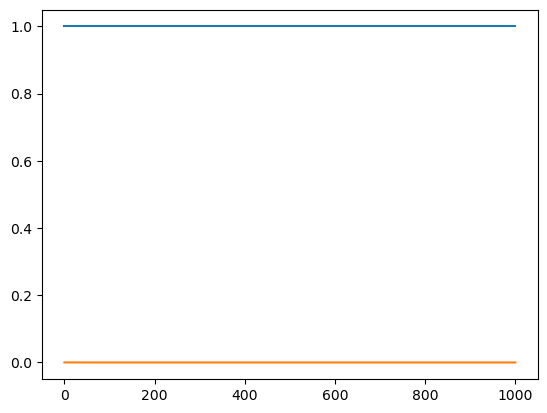

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F45A36590>

In [84]:
PyPlot.plot(in_thruster)
PyPlot.plot(in_rudder)

In [85]:
# plot(xs[1:100], ys[1:100])
# PyPlot.plot(xs, ys)

In [86]:
# plot(xs)
# plot!(ys)

## Measurement Model

In [87]:
size(value_image)


(8112, 16212)

lookup_depth (generic function with 1 method)

In [89]:
x = -100000000000
y = -1000000000000000000000
x_idx = argmin(abs.(collect(1:size(bathy_map, 2)) .- x))
y_idx = argmin(abs.(collect(1:size(bathy_map, 1)) .- y))
println(x_idx)
println(y_idx)

1
1


In [90]:
size(bathy_map)

# if 5 <= 1 || 4 <= 25
#     print("hi")
# end

(1001, 2001)

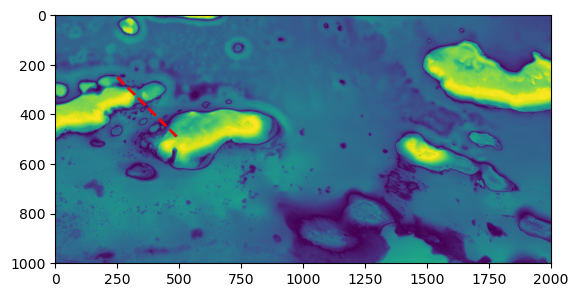

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F458C2440>

In [97]:

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)


# heatmap(bathy_map, aspect_ratio=:equal, color=:grays)
# plot!(600,600)
# plot!(x, y, color=:red, lw=2)
ax.plot([250,500],[250,500],"r--", lw=2)

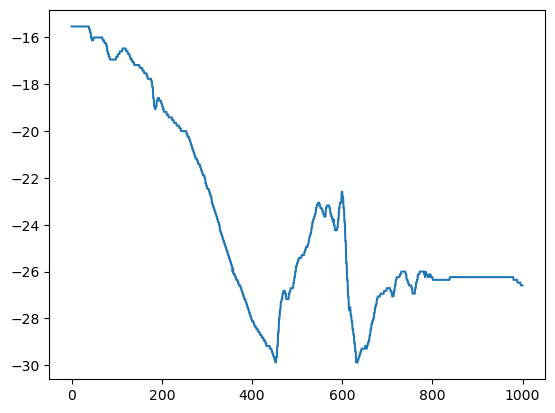

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F45639090>

In [99]:
measurements = simulate_measurements(xs, ys, bathy_map)
PyPlot.plot(ts, -measurements)

## Particle Filter

compute_likelihood (generic function with 1 method)

In [49]:
using Reel # For visualization
plot_sequence = []




5

In [50]:
# function sample_points(initial_state, noise_distribution, num_points)
#     ...
#     particles = ones(, N_PARTICLES)
    
#     for i in range(1, num_points)
#         sample = initial_state + rand.(initial_distribution)
#     end
    
#     return samples
# end

# function update_weights!(particles, dynamics_model, observation)
#     ...

# function compute_likelihood(state, observation, observation_model)
#     ...
        
#     # State vector: x, y, θ, linear velocity, angular velocity
#     x, y, θ, v, dθ = state

#     model_depth = lookup_depth(x, y, map)

#     dist = Normal(model_depth, MODEL_MEASUREMENT_STD)
#     pdf_value = pdf(dist, measurement)
    
# #     println(model_depth)
# #     println(pdf_value)
#     return pdf_value
# end

# function resample_points!(particles, weights)
#     ...
        

            

In [51]:
rand.([dist_pos_init, dist_pos_init])

2-element Vector{Float64}:
 -63.92874007791153
  96.68746732981522

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

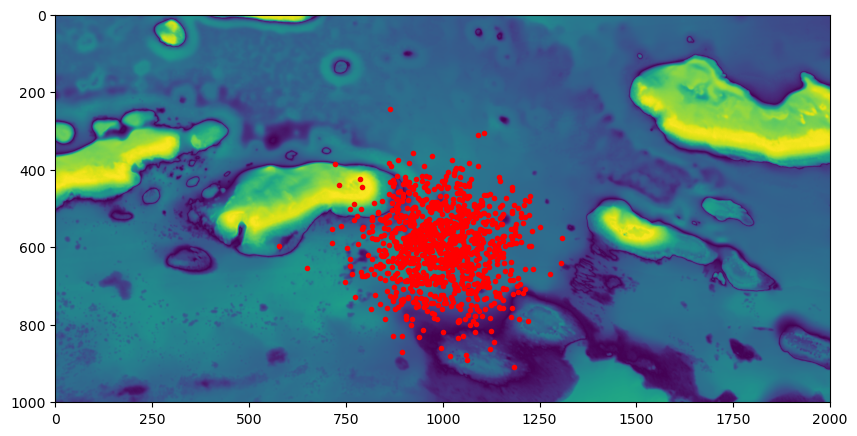

In [52]:

# INITIALIZATION ##############################################
all_particles = ones(STATE_VEC_SIZE, N_PARTICLES, N_STEPS)
particles = ones(STATE_VEC_SIZE, N_PARTICLES)
new_particles = ones(STATE_VEC_SIZE, N_PARTICLES)
weights = ones(N_PARTICLES)


dist_pos_init = Normal(0, INIT_STD_POS)
dist_rot_init = Normal(0, INIT_STD_ROT)

dist_pos_update = Normal(0, PF_STD_POS)
dist_rot_update = Normal(0, PF_STD_ROT)


for i in range(1, N_PARTICLES)
    # Generate sample
    x = START_X + rand(dist_pos_init)
    y = START_Y + rand(dist_pos_init)
    θ = START_θ + rand(dist_rot_init)
    
    particles[:,i] = particles[:,i].*[x, y, θ, 0, 0]
end

# Plot initial particles
fig, ax = PyPlot.subplots(figsize=[10,10])
ax.imshow(-bathy_map)
ax.plot(particles[1,:], particles[2,:], "r.")


# PARTICLE FILTER ##############################################
state_estimate = ones(STATE_VEC_SIZE, N_STEPS)

# pre-allocate space (avoids errors)
samples = similar(weights)

for (t_idx, (t, m, in_th, in_rud)) in enumerate(zip(ts, measurements, in_thruster, in_rudder))
    print('.')
    all_particles[:,:,t_idx] = particles
    
    
    # Update weights based on observation ---------------------
    # Compute relative likelihoods
    for (p_idx, p) in enumerate(eachcol(particles))
        weights[p_idx] = compute_likelihood(p, m, bathy_map)
        
        # Ensure likelihood can't be too small
        if weights[p_idx] < 0.000000001
            weights[p_idx] = 0.000000001
        end
    end   
    
    # Resample particles --------------------------------------
    # Normalize the weights

    
#     println("HEREEE")
#     println(size(weights))
#     println(sum(weights))
#     println(size(weights ./ sum(weights)))
    
    w_norm = Weights(weights ./ sum(weights))

    # Generate N_PARTICLES samples
    samples = sample(1:size(particles, 2), w_norm, N_PARTICLES)

    # Extract the corresponding columns from the matrix
    new_particles = particles[:, samples]
    particles = new_particles
    
    # Add noise to avoid particle death
    # TODO: Add noise to samples based on current covariances
    particles[1, :] = particles[1, :] + rand(dist_pos_update, N_PARTICLES)
    particles[2, :] = particles[2, :] + rand(dist_pos_update, N_PARTICLES)
    particles[3, :] = particles[3, :] + rand(dist_rot_update, N_PARTICLES)
    
    # Update particles with dynamics model 
    # TODO add vehicle dynamics noise? (build in noise term here)
    for (p_idx, p) in enumerate(eachcol(particles))
        particles[:,p_idx] = glider_dynamics_model(p, DELTA_T, in_th, in_rud)
    end   
    
    # Update state estimate --------------------------------------
    state_estimate[:,t_idx] = mean(particles, dims=2) # TODO: Handle angle wrap elegantly
    
#     # Visualization -------------------------------------------
#     fig, ax = PyPlot.subplots()
#     ax.imshow(-bathy_map)
#     ax.plot(particles[1,:], particles[2,:], "r.")

#     # Add the plot to the sequence
#     push!(plot_sequence, fig)
end



# w = [1,1,1,2,3,4,5,6,7]

# idxs = sample(axes(b, 1), myweights, 10)

# INITIALIZATION

# SIM_TIME = 1000 # s
# N_STEPS = 1001

# START_X = 1000 
# START_Y = 600
# START_θ = π/2

# state_vec = 
# particles



# Implement Particle filter
# - given
#     in_thruster
#     in_rudder
# - given initialization (put at map size/2)
# - randomly generate particles around starting position (x, y, theta) - Note: use gaussians here. Use defined covariance
# - plot initial particles

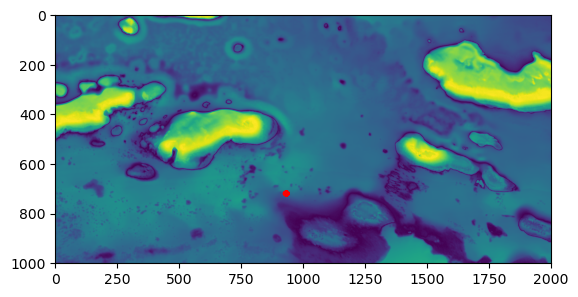

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F2BE626B0>

In [53]:
# Plot particles at step n

n = 100

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(all_particles[1,:,n], all_particles[2,:,n], "r.")

In [54]:
# # dist_pos_init = Normal(0, INIT_STD_POS)
# dist_rot_init = Normal(0, INIT_STD_ROT)
# rand(dist_pos_init, 10) + rand(dist_pos_init, 10)

In [55]:
# frames = Frames(MIME("image/png"), fps=10)
# for plt in plot_sequence
#     print(".")
#     push!(frames, plt)
# end
# write("output.gif", frames)


# using Interact, Plots

# Define the function to plot
# f(x) = sin(x)

# Create a slider widget
# s = slider(0:0.1:2π, label="x")

# # Create a plot that updates with the slider
# plot(slider = s) do
#     plot(f.(s.value), label="sin(x)")
#     xlabel("x")
#     ylabel("y")
#     ylim(-1.1, 1.1)
# end

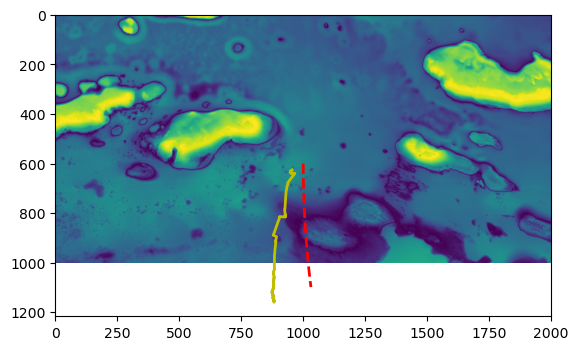

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F2BEE61A0>

In [56]:
# Plot result
# fig, ax = PyPlot.subplots(figsize=[10,10])
fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(state_estimate[1,:], state_estimate[2,:], "y-", lw=2)
ax.plot(xs,ys,"r--", lw=2)

In [26]:
# particles = ones(STATE_VEC_SIZE, N_PARTICLES)
# A = rand(5, 10)
# row_means = mean(A, dims=2)

In [27]:
mat = rand(3,10)
display(mat)
print(size([1,1,1,1,1,2,3,4,5,100]))
w = pweights([1,1,1,1,1,2,3,4,5,1000])

idxs = sample(axes(mat,2), w, 10)

3×10 Matrix{Float64}:
 0.263024    0.534815  0.992894  0.480743  …  0.437964  0.832557  0.611114
 0.00397285  0.586192  0.795251  0.764921     0.831626  0.269864  0.142983
 0.696813    0.748456  0.229832  0.84537      0.990075  0.538914  0.956491

(10,)

10-element Vector{Int64}:
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10

In [28]:
# Example data
# mat = rand(3,10)
# w_unnormalized = [1,1,1,1,1,2,3,4,5,1000]
# p = w_unnormalized / sum(w_unnormalized)
# w = 1 ./ p
# w = w / sum(w)

# # Draw a sample from x using the weights in w
# sampled_index = sample(w_unnormalized, Weights(w), 1)

# Get the value of the sampled element from x
# sampled_value = x[1,sampled_index]



# RESAMPLE STEP #####################################


# Example data
mat = rand(3, 10)
w_unnormalized = [1, 1, 1, 1, 1, 2, 3, 4, 5, 1000]

# Normalize the weights
w = w_unnormalized ./ sum(w_unnormalized)

# Generate n samples
n = 5
samples = sample(1:size(mat, 2), Weights(w), n)

# Extract the corresponding columns from the matrix
sampled_mat = mat[:, samples]


3×5 Matrix{Float64}:
 0.595189   0.595189   0.393616  0.595189   0.595189
 0.0485249  0.0485249  0.147211  0.0485249  0.0485249
 0.921648   0.921648   0.819239  0.921648   0.921648

In [29]:
axes(mat,2)

Base.OneTo(10)

In [30]:
# using StatsBase

# # Define an array of values
# x = [2, 3, 5, 2, 10]

# # Compute weights based on the relative values of the elements in x
# w = x ./ sum(x)

# # Sample an index from x based on the computed weights
# # idx = rand(SampleWeights(w))


In [31]:
# bathy_map[1,400]
# bathy_map[1,800]
# maximum(bathy_map)
# minimum(bathy_map)
# plot(bathy_map[:,1]) # column, row format. 0, 0 is top left of image



In [32]:
print(img[10,10000])

# function rgb_to_greyscale(rgb)
# end
# 0.2989, 0.5870, 0.1140.

# gray_value = Gray(img[10,10000])

# gray_img = Gray.(img)

# # Plot the grayscale image
# heatmap(gray_img, color=:grays)

# float(red(img[6000,10000]))

rgb_to_value(img[6000,10000])

RGB{N0f8}(1.0,0.0,0.0)

12.941175f0

In [33]:

# # affine_map = geotransform(geoarray)
# # plot(geoarray, band=3)
# # geoarray
# # 0.299red+0.587green+0.114blue
# # band_1 = geoarray[:,:,1]

# using GeoArrays

# # Load the GeoTIFF file into a GeoArray
# # filename = "path/to/geotiff/file.tif"
# # geoarray = GeoArrays.read(filename)

# # Define the latitude and longitude of the point of interest
# lat = 40.7128
# lon = -74.0060

# # Convert the latitude and longitude to row and column indices
# # setcrs!(geoarray, "+proj=longlat +datum=WGS84")
# # row, col = GeoArrays.coordinates(geoarray, lat, lon)

# # # Extract the RGB value at the specified location
# # rgb = geoarray[row, col, :]

# # # Convert the RGB value to depth
# # depth = 0.3048 * (rgb[1] + rgb[2] * 256 + rgb[3] * 65536)

# # # Print the depth value
# # println(depth)

In [34]:
# Define the x and y values
x = 100
y = 200

# Find the pixel with the closest x, y values
x_idx = argmin(abs.(collect(1:size(img, 2)) .- x))
y_idx = argmin(abs.(collect(1:size(img, 1)) .- y))

# Look up the pixel value
pixel_value = img[y_idx, x_idx]
print(pixel_value)

RGB{N0f8}(0.69,0.882,0.0)

### Map Generation

In [35]:
using Plots
using CalculusWithJulia
import Contour: contours, levels, lines, coordinates
using LinearAlgebra, ForwardDiff

LoadError: ArgumentError: Package CalculusWithJulia not found in current path.
- Run `import Pkg; Pkg.add("CalculusWithJulia")` to install the CalculusWithJulia package.

In [36]:
# Step 1
n = rand(5:20)

# Step 2
A = rand(-1:0.01:1, n)
B = rand(0.001:0.005:0.05, n)
f_rand(x,y) = sum(A[i]*sin.(B[i]*x) * A[i+1]*cos.(B[i+1]*y) for i in 1:n-1)


f_rand (generic function with 1 method)

In [37]:
xs = range(-200, stop=200, length=100)
ys = range(-200, stop=200, length=100)
# f(x,y) = sin(x/100)*sin(y/100)
# f(x,y) = sin(x/100)*sin(y/100)
# surface(xs, ys, f)
contour(xs, ys, f_rand)

LoadError: UndefVarError: contour not defined

In [38]:
f_rand(xs, ys)

LoadError: MethodError: no method matching *(::Vector{Float64}, ::Vector{Float64})
[0mClosest candidates are:
[0m  *(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at operators.jl:591
[0m  *([91m::StridedMatrix{T}[39m, ::StridedVector{S}) where {T<:Union{Float32, Float64, ComplexF32, ComplexF64}, S<:Real} at C:\Users\amyng\AppData\Local\Programs\Julia-1.8.5\share\julia\stdlib\v1.8\LinearAlgebra\src\matmul.jl:49
[0m  *(::StridedVecOrMat, [91m::LinearAlgebra.Adjoint{<:Any, <:LinearAlgebra.LQPackedQ}[39m) at C:\Users\amyng\AppData\Local\Programs\Julia-1.8.5\share\julia\stdlib\v1.8\LinearAlgebra\src\lq.jl:269
[0m  ...

In [39]:
using PyPlot

In [40]:
function meshgrid(x, y)
    X = [i for i in x, j in 1:length(y)]
    Y = [j for i in 1:length(x), j in y]
    return X, Y
end

meshgrid (generic function with 1 method)

### Lookup values

In [ ]:
function simulate_measurement(x,y,theta,noise=0)
    # TODO: Returns beam 1, 2, 3, 4
    return f_rand(x, y)
end

In [ ]:
# End goal: plot of real trajectory, 
# versus computed one with particle filter

## GPU code snippets

In [ ]:
# # Initialize particles
# x_d = CuArray{Float32}(START_X .+ rand(dist_pos_init, N_PARTICLES))
# y_d = CuArray{Float32}(START_Y .+ rand(dist_pos_init, N_PARTICLES))
# θ_d = CuArray{Float32}(START_θ .+ rand(dist_rot_init, N_PARTICLES))
# v_d = CUDA.fill(0.0f0, N_PARTICLES)  # a vector stored on the GPU filled with 1.0 (Float32)
# dθ_d = CUDA.fill(0.0f0, N_PARTICLES)

# # Particles = Vector containing CuArray for each state variable 
# # Vector{CuArray}(undef, 5)
# particles_d = CuArray([x_d, y_d, θ_d, v_d, dθ_d])

# # Load measurements and control inputs onto GPU
# in_thruster_d = CuArray{Float32}(in_thruster)
# in_rudder_d = CuArray{Float32}(in_rudder)

# inputs_d = [in_thruster_d, in_rudder_d]
# measurements_d = [CuArray{Float32}(measurements)]
